# Homework #5 - Ravi Raghavan

In [1]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt

## Theoretical Calculations of Gradient and Hessian

$f(x) = - \sum_{i=1}^{m} \log{(1 - a_i^Tx)} - \sum_{i=1}^{n} \log{(1 - x_i^2)}$

$x \in \mathbb{R}^n$ and $dom f = \{ x | a_i^Tx < 1, i = 1, 2, ..., m, |x_i| < 1, i = 1, 2, ..., n\}$


This can also be expressed as 

$f(x) = - \sum_{i=1}^{m} \log{(1 - a_i^Tx)} - \sum_{i=1}^{n} \log{(1 - x_i)} - \sum_{i=1}^{n} \log{(1 + x_i)}$

$x \in \mathbb{R}^n$ and $dom f = \{ x | a_i^Tx < 1, i = 1, 2, ..., m, |x_i| < 1, i = 1, 2, ..., n\}$


$\frac{\partial{f}}{\partial{x_j}} = - (\sum_{i=1}^{m} (\frac{1}{1 - a_i^Tx}) (-a_{ij})) - \frac{1}{(1 - x_j^2)} (-2x_j)$

$\frac{\partial{f}}{\partial{x_j}} =  \sum_{i=1}^{m} (\frac{a_{ij}}{1 - a_i^Tx}) + \frac{2x_j}{(1 - x_j^2)}$


$\frac{\partial{f}}{\partial{x_k} \partial{x_j}}$: 

Case where $j = k$:

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} a_{ij} (\frac{-1}{(1 - a_i^Tx)^2}) (-a_{ik}) + \frac{2(1 - x_j^2) - 2x_j(-2x_j)}{(1 - x_j^2)^2}$

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})  + \frac{2(1 + x_j^2)}{(1 - x_j^2)^2}$

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})  + \frac{2(1 + x_j^2)}{(1 - x_j^2)^2}$


Case where $j \neq k$: 

$\frac{\partial{f}}{\partial{x_k} \partial{x_j}} = \sum_{i=1}^{m} (\frac{a_{ij} a_{ik}}{(1 - a_i^Tx)^2})$





## Programmatic Implementations of Descent Methods

In [2]:
#Function to Perform Gradient Descent
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
def gradient_descent(f, gradient, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store step sizes
    step_sizes = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient        
        print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}")
        
        #if we have satisfied our convergence criteria, break from loop
        if np.linalg.norm(grad) <= eta:
            break
        
        descent_direction = -1 * grad #our descent direction is the negative gradient
        step_size = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (step_size * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        step_sizes.append(step_size) #Store step size
    
    #store function value in array
    function_values = np.array(function_values)
    step_sizes = np.array(step_sizes)
    return points, function_values, step_sizes

In [3]:
#H: Hessian of function at a given point
#g: gradient of function at given point
#This function solves the system H @ x_nt = -g to calculate the newton direction
def solve_newton_system(H: np.ndarray, g: np.ndarray):
    L = np.linalg.cholesky(H) #compute Cholesky Decomposition of H
    n = L.shape[0]
    
    #forward substitution to solve Lw = b where b = -g
    w = np.zeros(shape = g.shape)
    b = -1 * g
    
    w[0, 0] = b[0, 0] / L[0, 0]
    for idx in range(1, n):
        w[idx, 0] = (b[idx, 0] - np.dot(L[idx, :idx].flatten(), w[:idx, 0].flatten())) / L[idx, idx]
    
    #backward substitution to solve L^T @ x_nt = w
    L_transpose = L.T
    x_nt = np.zeros(shape = g.shape)
    
    x_nt[n - 1, 0] = w[n - 1, 0] / L_transpose[n - 1, n - 1]
    for idx in range(n - 2, -1, -1):
        x_nt[idx, 0] = (w[idx, 0] - np.dot(L_transpose[idx, -1:idx:-1].flatten(), x_nt[-1:idx:-1, 0].flatten())) / L_transpose[idx, idx]
    
    #Calculate lambda^2
    lambda_squared = np.linalg.norm(w) ** 2
    
    ##Sanity Check
    closed_form = -1 * (np.linalg.inv(H) @ g)
    assert np.allclose(x_nt, closed_form)
    
    return x_nt, lambda_squared

In [4]:
#Function to Perform Newton's Method
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#hessian: compute hessian of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
def newton_descent(f, gradient, hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store step sizes
    step_sizes = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        H = hessian(A, x) #compute hessian
        newton_direction, newton_parameter = solve_newton_system(H, grad) #Solve the system H @ x_nt = -g to calculate the newton direction where H is the Hessian and g is the gradient
        print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}, Norm of Hessian: {np.linalg.norm(H)}, Newton Parameter: {newton_parameter}")
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
        
        descent_direction = newton_direction #our descent direction is the newton direction
        step_size = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (step_size * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        step_sizes.append(step_size) #Store step size
    
    #store function value in array
    function_values = np.array(function_values)
    step_sizes = np.array(step_sizes)
    return points, function_values, step_sizes

In [5]:
#Function to Perform Newton's Method where the Hessian is reused every N iterations
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#hessian: compute hessian of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
#N: number of iterations after which Hessian is evaluated
def reuse_newton_descent(f, gradient, hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta, N):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store step sizes
    step_sizes = []
    
    #Store Hessians
    hessians = []
    H = hessian(A, x) #compute hessian
    hessians.append(H)
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        
        #Get Hessian
        if (iter > 0) and (iter % N == 0):
            H = hessian(A, x)
            hessians.append(H)
        else:
            H = hessians[-1]
        
        newton_direction, newton_parameter = solve_newton_system(H, grad) #Solve the system H @ x_nt = -g to calculate the newton direction where H is the Hessian and g is the gradient
        print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}, Norm of Hessian: {np.linalg.norm(H)}, Newton Parameter: {newton_parameter}")
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
        
        descent_direction = newton_direction #our descent direction is the newton direction
        step_size = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (step_size * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        step_sizes.append(step_size) #Store step size
    
    #store function value in array
    function_values = np.array(function_values)
    step_sizes = np.array(step_sizes)
    return points, function_values, step_sizes

In [6]:
#Function to Perform Newton's Method where the Hessian is approximated by its diagonal
#f: Compute function value at given point
#gradient: compute gradient of function at given point
#hessian: compute hessian of function at given point
#backtracking_algorithm: function used to perform backtracking
#A: matrix of ai vectors where ai are the rows of A
#x0: initial point of gradient descent
#max_iter: maximum number of iterations of Gradient Descent to run 
#eta: used in convergence criteria
#alpha: alpha parameter for backtracking
#beta: beta parameter used for backtracking
def diagonal_newton_descent(f, gradient, diagonal_hessian, backtracking_algorithm, A: np.ndarray, x0: np.ndarray, max_iter, eta, alpha, beta):
    #Set initial iterate and function value
    x = x0
    fx = f(A, x)
    
    #maintain arrays to store iterates and function values throughout gradient descent
    points = np.array([x])
    function_values = []
    function_values.append(fx)
    
    #Store alphas
    step_sizes = []
    
    #enter for loop of max_iter times
    for iter in range(max_iter):
        grad = gradient(A, x) #compute gradient
        H = diagonal_hessian(A, x) #compute diagonal hessian
        newton_direction, newton_parameter = solve_newton_system(H, grad) #Solve the system H @ x_nt = -g to calculate the newton direction where H is the Hessian and g is the gradient
        print(f"Iteration: {iter + 1}, Max of A @ x: {np.max(A @ x)}, Max of x^2: {np.max(np.square(x))}, Current Function Value(Beginning of Iteration): {fx}, Norm of Gradient: {np.linalg.norm(grad)}, Norm of Hessian: {np.linalg.norm(H)}, Newton Parameter: {newton_parameter}")
        
        #if we have satisfied our convergence criteria, break from loop
        if newton_parameter <= eta:
            break
        
        descent_direction = newton_direction #our descent direction is the newton direction
        step_size = backtracking_algorithm(A, x, descent_direction, alpha, beta) #compute best step size
        x = x + (step_size * descent_direction) #compute next iterate
        
        points = np.append(points, x[np.newaxis, :, :], axis=0) #store point in points array
        fx = f(A, x) #calculate updated function value
        function_values.append(fx) #store updated function value
        step_sizes.append(step_size) #Store alpha
    
    #store function value in array
    function_values = np.array(function_values)
    step_sizes = np.array(step_sizes)
    return points, function_values, step_sizes

In [7]:
#A: Matrix such that each row of A is ai
#x: x
#This function, given A and x, check to see if x is within the domain of f
#returns True if x is in the domain of f 
#returns False is x is NOT in the domain of f
def domain_check(A: np.ndarray, x: np.ndarray):
    B = A @ x
    max_B = np.max(B)
    max_x = np.max(np.abs(x))
    return max_B < 1 and max_x < 1

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    B = A @ x
    
    log_comp_B = np.log(1 - B)
    log_plus_x = np.log(1 + x)
    log_minus_x = np.log(1 - x)
    
    return (-1 * np.sum(log_comp_B)) - np.sum(log_plus_x) - np.sum(log_minus_x)

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the gradient of function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f_gradient(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x    
    gradient_vector = (A.T @ (1 / (1 - B))) + (1 / (1 - x)) - (1 / (1 + x))    
    return gradient_vector   

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the Hessian of function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f_hessian(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    C = 1 / (1 - B)
    C_squared = C ** 2
    C_squared = C_squared.flatten()
    
    plus_x_squared = 1 / ((1 + x) ** 2)
    minus_x_squared = 1 / ((1 - x) ** 2)
    combined = plus_x_squared + minus_x_squared
    combined = combined.flatten()
    
    H = (A.T @ np.diag(C_squared) @ A) + np.diag(combined)    
    return H

#A: Matrix such that each row of A is ai
#x: x
#Compute the value of the Diagonal Approximation of Hessian of function at x, given A. 
#If x is not in the domain of f, infinity is returned
def f_diagonal_hessian(A: np.ndarray, x: np.ndarray):
    if not domain_check(A, x):
        return np.inf
    
    B = A @ x
    C = 1 / (1 - B)
    C_squared = C ** 2
    
    A_transpose_squared = ((A.T) ** 2)
    D = A_transpose_squared @ C_squared
    D = D.flatten()
    
    plus_x_squared = 1 / ((1 + x) ** 2)
    minus_x_squared = 1 / ((1 - x) ** 2)
    combined = plus_x_squared + minus_x_squared
    combined = combined.flatten()
    
    H = np.diag(D) + np.diag(combined)    
    return H

#This function performs backtracking
#A: Matrix such that each row of A is ai
#x: x
#delta_x: search direction
#alpha: alpha parameter
#beta: beta parameter
def f_backtracking_algorithm(A: np.ndarray, x: np.ndarray, delta_x: np.ndarray, alpha, beta):
    t = 1
    
    #First we must multiply t by Beta until we get within the domain
    while not domain_check(A, x + (t * delta_x)):
        t = beta * t
    
    #Multiply t by beta until the backtracking stopping condition is met
    while (f(A, x + (t * delta_x))) > (f(A, x) + (alpha * t * (f_gradient(A, x).T @ delta_x))):
        t = beta * t
            
    return t 

## 9.30 (a): Gradient Descent Method with Backtracking Line Search

### Experiment #1: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.1$ 

In [8]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.1
eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [9]:
## Investigate Matrix A
max_A = np.max(A)
min_A = np.min(A)
print(f"Minimum Element in A: {min_A}")
print(f"Maximum Element in A: {max_A}")

Minimum Element in A: -4.4466322413592945
Maximum Element in A: 3.8016602149671153


In [10]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star_seed0 = gradient_descent_function_values[-1] #the optimal function value is approximated as the last function value that we observed during gradient descent

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447
Iteration: 2, Max of A @ x: 0.33576180535297867, Max of x^2: 0.0015035943815370583, Current Function Value(Beginning of Iteration): -17.763355412888966, Norm of Gradient: 108.05030640793125
Iteration: 3, Max of A @ x: 0.49451612553900676, Max of x^2: 0.004219093209209788, Current Function Value(Beginning of Iteration): -28.441231444610754, Norm of Gradient: 90.87488665259288
Iteration: 4, Max of A @ x: 0.5513662454921213, Max of x^2: 0.007778077686068094, Current Function Value(Beginning of Iteration): -36.19433481966988, Norm of Gradient: 80.34988535930829
Iteration: 5, Max of A @ x: 0.5612291137116627, Max of x^2: 0.01211196713938813, Current Function Value(Beginning of Iteration): -42.34128762980464, Norm of Gradient: 72.95123972107741
Iteration: 6, Max of A @ x: 0.5600576865382161, Max of x^2: 0.016954190938167118, Current Function Value(Beginn

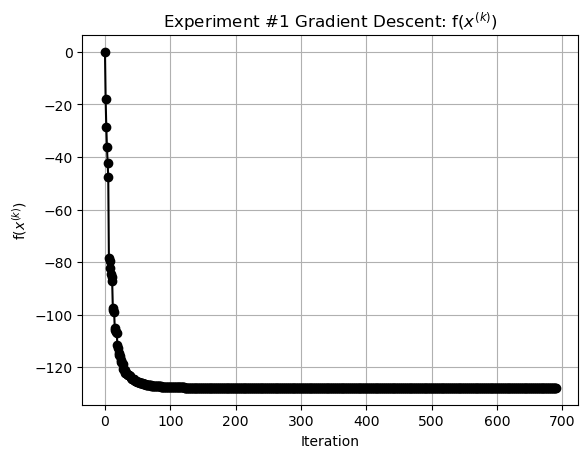

In [11]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #1 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

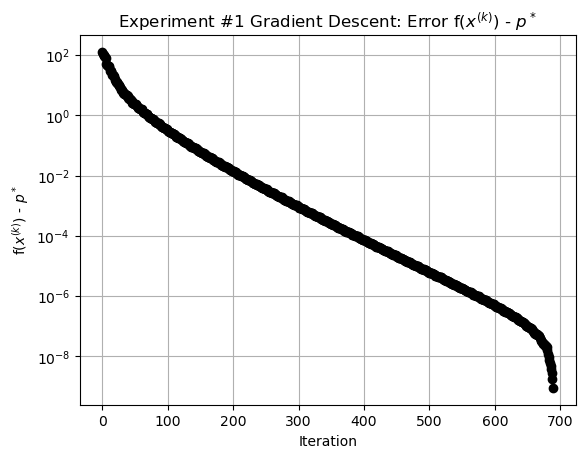

In [12]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [13]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #1 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #2: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.5$ 

In [14]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [15]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447
Iteration: 2, Max of A @ x: 0.6557847760800363, Max of x^2: 0.005735757375858526, Current Function Value(Beginning of Iteration): -30.346237811575143, Norm of Gradient: 87.45413359419904
Iteration: 3, Max of A @ x: 0.7087313461964355, Max of x^2: 0.02484339872470881, Current Function Value(Beginning of Iteration): -54.04848841315089, Norm of Gradient: 63.7652124075385
Iteration: 4, Max of A @ x: 0.9790318930898736, Max of x^2: 0.0546890333044766, Current Function Value(Beginning of Iteration): -63.88970700819919, Norm of Gradient: 518.9269161092963
Iteration: 5, Max of A @ x: 0.6287648093197479, Max of x^2: 0.04933007035718777, Current Function Value(Beginning of Iteration): -65.87993883220199, Norm of Gradient: 59.18463304773217
Iteration: 6, Max of A @ x: 0.8351609233718504, Max of x^2: 0.08256225219018788, Current Function Value(Beginning of Ite

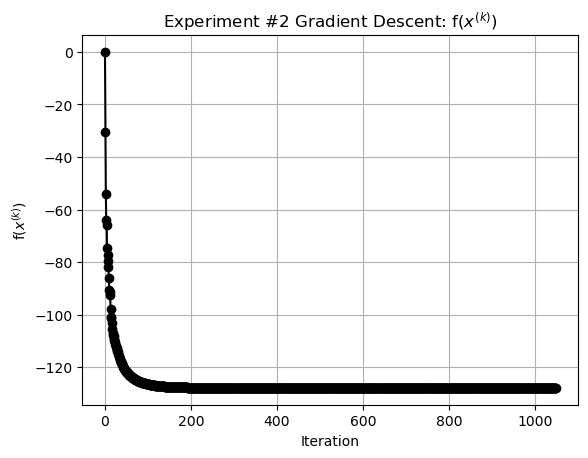

In [16]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #2 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

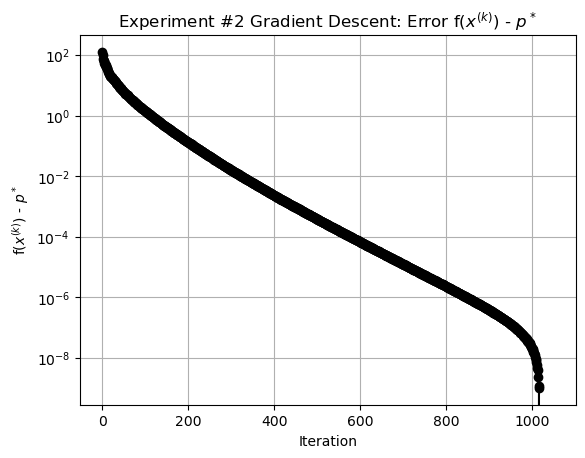

In [17]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

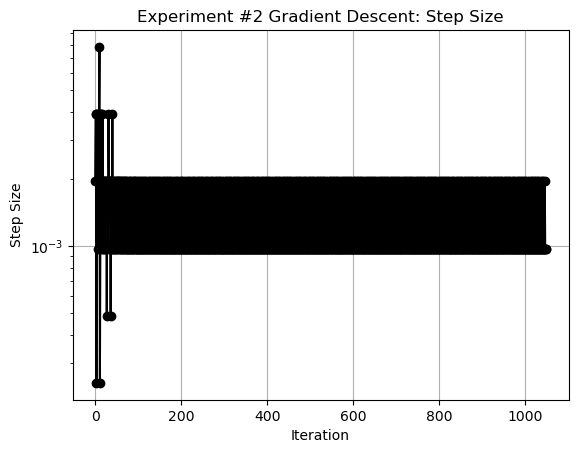

In [18]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #2 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #3: n = 100, m = 200, $\alpha = 0.15$, $\beta = 0.1$ 

In [19]:
#Global Variables
n = 100
m = 200
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [20]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447
Iteration: 2, Max of A @ x: 0.33576180535297867, Max of x^2: 0.0015035943815370583, Current Function Value(Beginning of Iteration): -17.763355412888966, Norm of Gradient: 108.05030640793125
Iteration: 3, Max of A @ x: 0.49451612553900676, Max of x^2: 0.004219093209209788, Current Function Value(Beginning of Iteration): -28.441231444610754, Norm of Gradient: 90.87488665259288
Iteration: 4, Max of A @ x: 0.5513662454921213, Max of x^2: 0.007778077686068094, Current Function Value(Beginning of Iteration): -36.19433481966988, Norm of Gradient: 80.34988535930829
Iteration: 5, Max of A @ x: 0.5612291137116627, Max of x^2: 0.01211196713938813, Current Function Value(Beginning of Iteration): -42.34128762980464, Norm of Gradient: 72.95123972107741
Iteration: 6, Max of A @ x: 0.5600576865382161, Max of x^2: 0.016954190938167118, Current Function Value(Beginn

In [21]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #3 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

In [22]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed0
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

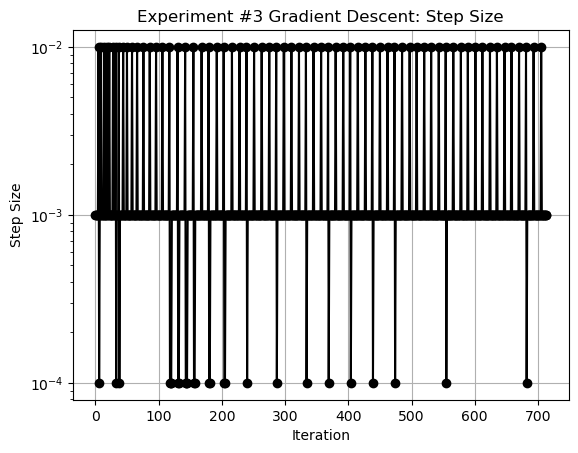

In [23]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #3 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #4: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.1$ 

In [24]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [25]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star_seed1 = gradient_descent_function_values[-1] #the optimal function value is approximated as the last function value that we observed during gradient descent

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704
Iteration: 2, Max of A @ x: 0.7334785802728112, Max of x^2: 0.0033927177179260528, Current Function Value(Beginning of Iteration): -65.29992806772917, Norm of Gradient: 178.82244592452693
Iteration: 3, Max of A @ x: 0.5926088769967657, Max of x^2: 0.008561587154349829, Current Function Value(Beginning of Iteration): -93.33936314870978, Norm of Gradient: 148.7349957151958
Iteration: 4, Max of A @ x: 0.7310778945011691, Max of x^2: 0.016303868622430318, Current Function Value(Beginning of Iteration): -113.6967923335915, Norm of Gradient: 131.8263612665154
Iteration: 5, Max of A @ x: 0.6177671360749254, Max of x^2: 0.026294302678057862, Current Function Value(Beginning of Iteration): -129.86910869612126, Norm of Gradient: 120.76178200812821
Iteration: 6, Max of A @ x: 0.7183025283562315, Max of x^2: 0.03612289714411554, Current Function Value(Beginni

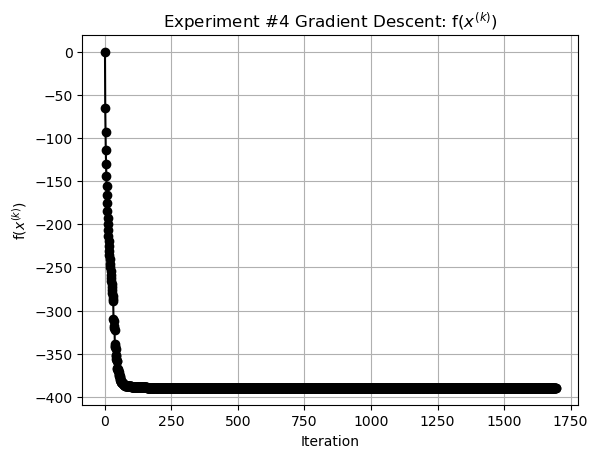

In [26]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #4 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

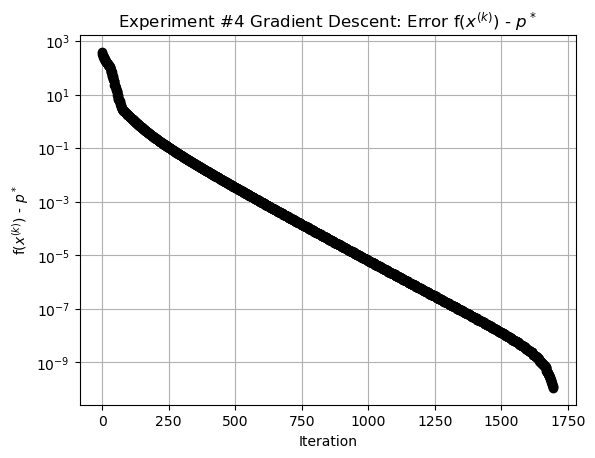

In [27]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #4 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

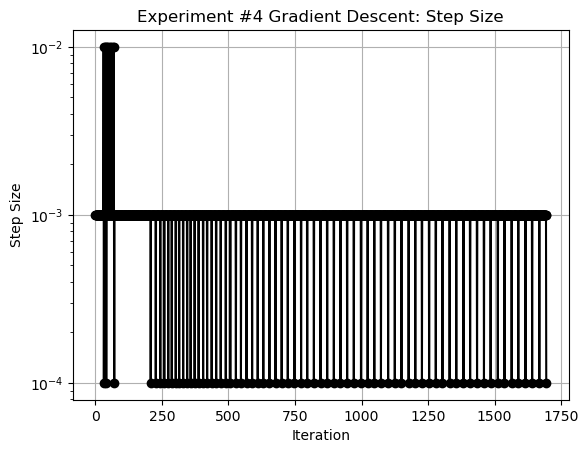

In [28]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #4 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #5: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.5$ 

In [29]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [30]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704
Iteration: 2, Max of A @ x: 0.7162876760476671, Max of x^2: 0.003235547750402499, Current Function Value(Beginning of Iteration): -64.27540105747023, Norm of Gradient: 179.27927972928026
Iteration: 3, Max of A @ x: 0.7871385141047141, Max of x^2: 0.017516707436586103, Current Function Value(Beginning of Iteration): -113.9335522898865, Norm of Gradient: 144.41734803633912
Iteration: 4, Max of A @ x: 0.7203947491635249, Max of x^2: 0.02699221584891909, Current Function Value(Beginning of Iteration): -130.09893555974688, Norm of Gradient: 126.57378292752377
Iteration: 5, Max of A @ x: 0.7311778143906228, Max of x^2: 0.03650869479322375, Current Function Value(Beginning of Iteration): -143.73468184434776, Norm of Gradient: 114.87999225617007
Iteration: 6, Max of A @ x: 0.898935414112016, Max of x^2: 0.06218374303710233, Current Function Value(Beginnin

In [31]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #5 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

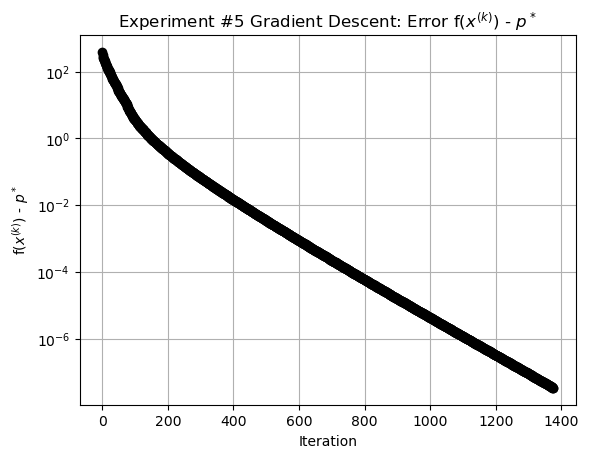

In [32]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #5 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

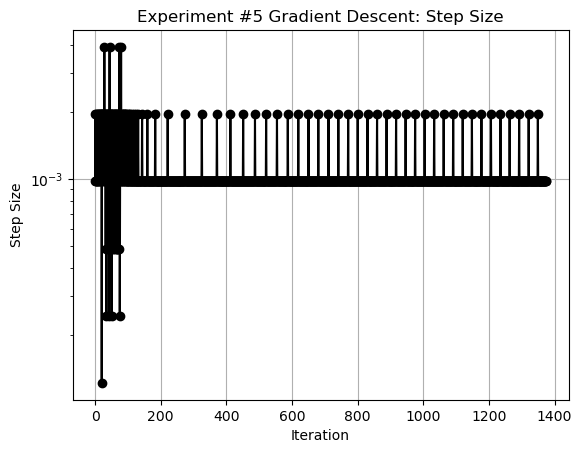

In [33]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #5 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #6: n = 200, m = 400, $\alpha = 0.15$, $\beta = 0.1$ 

In [34]:
#Global Variables
n = 200
m = 400
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [35]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704
Iteration: 2, Max of A @ x: 0.7334785802728112, Max of x^2: 0.0033927177179260528, Current Function Value(Beginning of Iteration): -65.29992806772917, Norm of Gradient: 178.82244592452693
Iteration: 3, Max of A @ x: 0.5926088769967657, Max of x^2: 0.008561587154349829, Current Function Value(Beginning of Iteration): -93.33936314870978, Norm of Gradient: 148.7349957151958
Iteration: 4, Max of A @ x: 0.7310778945011691, Max of x^2: 0.016303868622430318, Current Function Value(Beginning of Iteration): -113.6967923335915, Norm of Gradient: 131.8263612665154
Iteration: 5, Max of A @ x: 0.6177671360749254, Max of x^2: 0.026294302678057862, Current Function Value(Beginning of Iteration): -129.86910869612126, Norm of Gradient: 120.76178200812821
Iteration: 6, Max of A @ x: 0.7183025283562315, Max of x^2: 0.03612289714411554, Current Function Value(Beginni

In [36]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #6 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

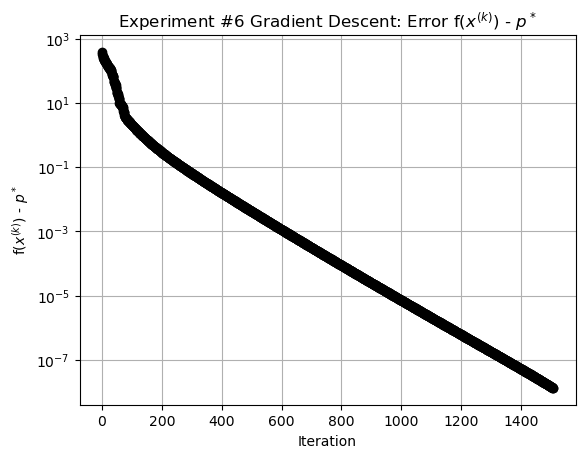

In [37]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed1
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #6 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

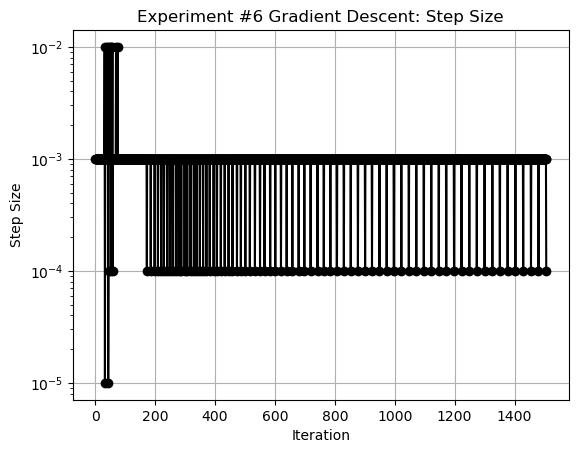

In [38]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #6 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #7: n = 50, m = 100, $\alpha = 0.01$, $\beta = 0.1$ 

In [39]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [40]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)
p_star_seed2 = gradient_descent_function_values[-1] #the optimal function value is approximated as the last function value that we observed during gradient descent

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863
Iteration: 2, Max of A @ x: 0.11177416877194024, Max of x^2: 0.00045218409149739165, Current Function Value(Beginning of Iteration): -5.346004911335945, Norm of Gradient: 65.24833910637672
Iteration: 3, Max of A @ x: 0.9926744895044831, Max of x^2: 0.043101315031587414, Current Function Value(Beginning of Iteration): -26.076378964855927, Norm of Gradient: 1022.0334385128156
Iteration: 4, Max of A @ x: 0.7700384368703103, Max of x^2: 0.04028318194425237, Current Function Value(Beginning of Iteration): -30.87104066704838, Norm of Gradient: 40.62660888311172
Iteration: 5, Max of A @ x: 0.7403498151536894, Max of x^2: 0.10911591429690304, Current Function Value(Beginning of Iteration): -35.63044080469716, Norm of Gradient: 53.62151189288862
Iteration: 6, Max of A @ x: 0.5848706419954677, Max of x^2: 0.10339880494737645, Current Function Value(Beginning

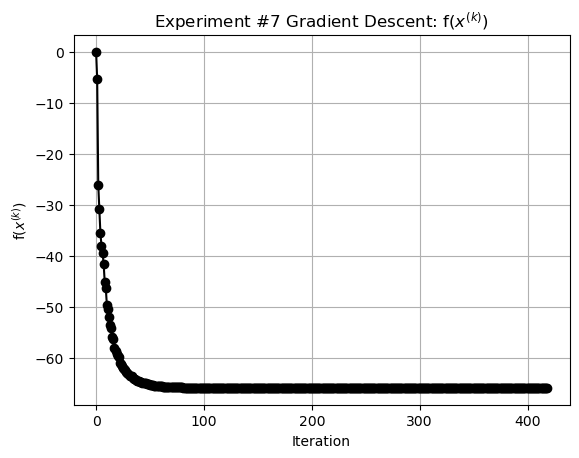

In [41]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #7 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

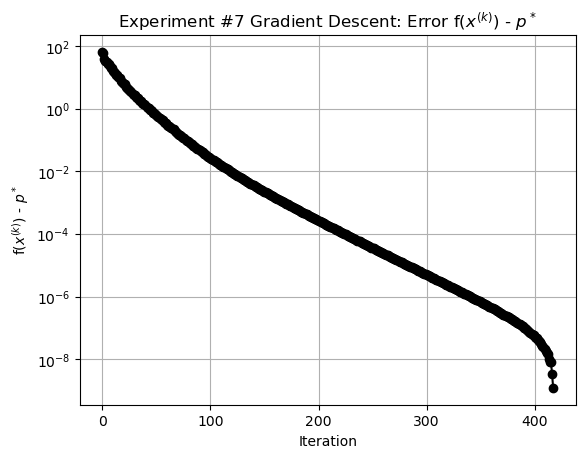

In [42]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
gradient_descent_gap_to_optimal = gradient_descent_gap_to_optimal[:-1]
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #7 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

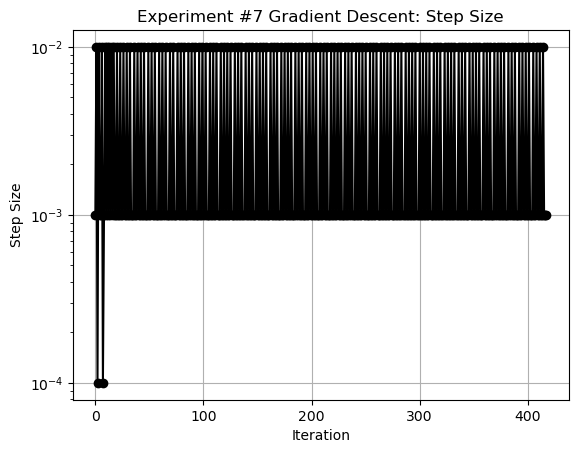

In [43]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #7 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #8: n = 50, m = 100, $\alpha = 0.01$, $\beta = 0.5$ 

In [44]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.5

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [45]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863
Iteration: 2, Max of A @ x: 0.8732356935307829, Max of x^2: 0.027599126678307585, Current Function Value(Beginning of Iteration): -25.89175413569806, Norm of Gradient: 69.061606084059
Iteration: 3, Max of A @ x: 0.5558494132903212, Max of x^2: 0.03982494890517159, Current Function Value(Beginning of Iteration): -28.994173066073316, Norm of Gradient: 43.739384850520686
Iteration: 4, Max of A @ x: 0.878929157901283, Max of x^2: 0.07772486871700354, Current Function Value(Beginning of Iteration): -36.30296631010149, Norm of Gradient: 69.50990637626326
Iteration: 5, Max of A @ x: 0.6307069841408349, Max of x^2: 0.10731890560102744, Current Function Value(Beginning of Iteration): -37.99176023517134, Norm of Gradient: 40.16827575433423
Iteration: 6, Max of A @ x: 0.8280807140809519, Max of x^2: 0.15515302951043988, Current Function Value(Beginning of Ite

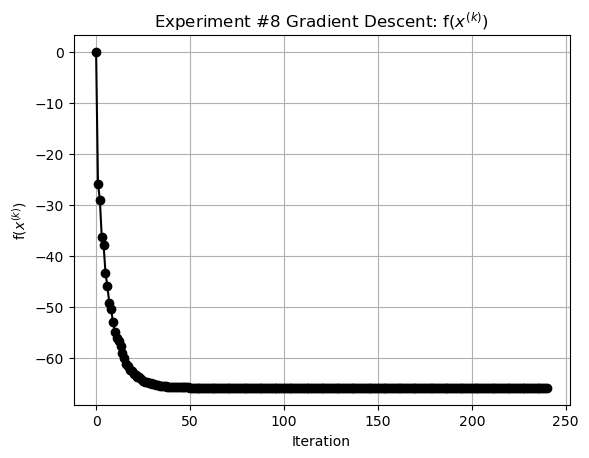

In [46]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #8 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

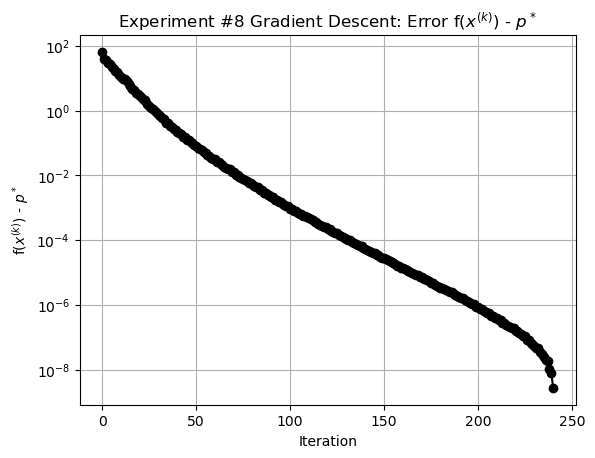

In [47]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #8 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

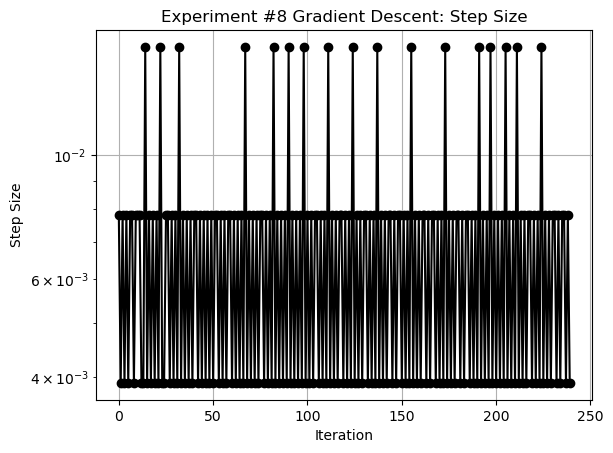

In [48]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #8 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #9: n = 50, m = 100, $\alpha = 0.15$, $\beta = 0.1$ 

In [49]:
#Global Variables
n = 50
m = 100
alpha = 0.15
beta = 0.1

eta = 1e-3
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [50]:
#Run Gradient Descent
gradient_descent_iterates, gradient_descent_function_values, gradient_descent_step_sizes = gradient_descent(f, f_gradient, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863
Iteration: 2, Max of A @ x: 0.11177416877194024, Max of x^2: 0.00045218409149739165, Current Function Value(Beginning of Iteration): -5.346004911335945, Norm of Gradient: 65.24833910637672
Iteration: 3, Max of A @ x: 0.9926744895044831, Max of x^2: 0.043101315031587414, Current Function Value(Beginning of Iteration): -26.076378964855927, Norm of Gradient: 1022.0334385128156
Iteration: 4, Max of A @ x: 0.9174281963925383, Max of x^2: 0.04281521451768754, Current Function Value(Beginning of Iteration): -28.64463171826734, Norm of Gradient: 125.79110004427373
Iteration: 5, Max of A @ x: 0.5855891381937615, Max of x^2: 0.04899438167428328, Current Function Value(Beginning of Iteration): -32.15604921706861, Norm of Gradient: 32.12517130032369
Iteration: 6, Max of A @ x: 0.8858615292964284, Max of x^2: 0.09196063201454464, Current Function Value(Beginnin

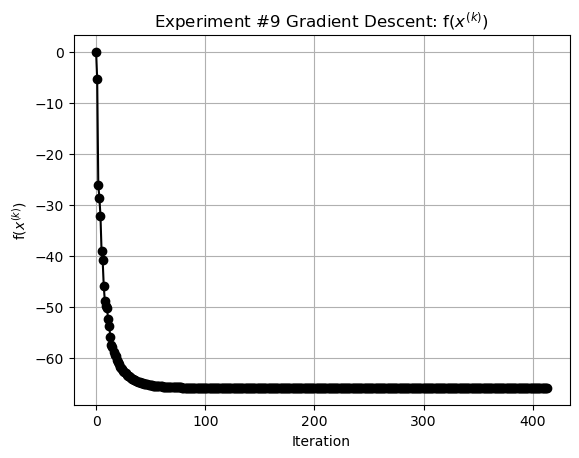

In [51]:
#Plot function values throughout gradient descent
plt.plot(list(range(len(gradient_descent_function_values))), gradient_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #9 Gradient Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

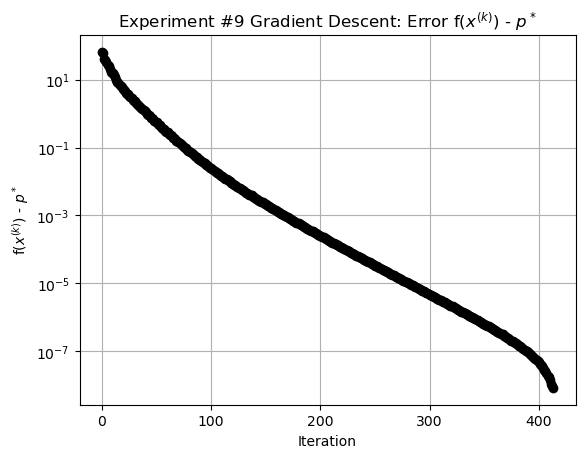

In [52]:
#Plot distance to optimal function value throughout gradient descent
gradient_descent_gap_to_optimal = gradient_descent_function_values - p_star_seed2
plt.plot(list(range(len(gradient_descent_gap_to_optimal))), gradient_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #9 Gradient Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

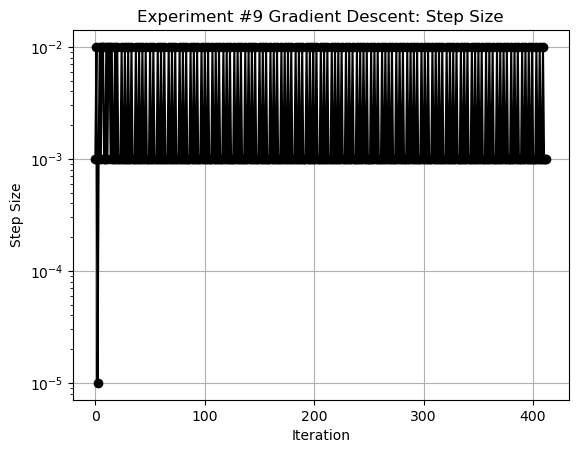

In [53]:
#Plot step sizes that were used during each iteration of gradient descent
plt.plot(list(range(len(gradient_descent_step_sizes))), gradient_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #9 Gradient Descent: Step Size')
plt.grid(True)
plt.show()

Observations:
- Backtracking Parameters $\alpha$ and $\beta$ affect the performance of Gradient Descent Algorithm
- Performance does not really scale well with problem size

## 9.30 (b)

### Experiment #1: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.1$ 

In [54]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.1
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [55]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447, Norm of Hessian: 2416.405817929144, Newton Parameter: 90.56343833315444
Iteration: 2, Max of A @ x: 0.10773966606246688, Max of x^2: 0.0005197028049616358, Current Function Value(Beginning of Iteration): -8.630023797973163, Norm of Gradient: 130.30037002317928, Norm of Hessian: 2229.063677787344, Newton Parameter: 89.5133755066185
Iteration: 3, Max of A @ x: 0.2050510002323914, Max of x^2: 0.0023495965769706976, Current Function Value(Beginning of Iteration): -17.15953273958938, Norm of Gradient: 118.39319700990535, Norm of Hessian: 2082.236963155713, Newton Parameter: 88.16174017255055
Iteration: 4, Max of A @ x: 0.29068598638790055, Max of x^2: 0.005944745720924914, Current Function Value(Beginning of Iteration): -25.559748564882955, Norm of Gradient: 107.53645755105855, Norm of Hessian: 1970.2747889424286, Newton Parameter: 86.49004392154205
It

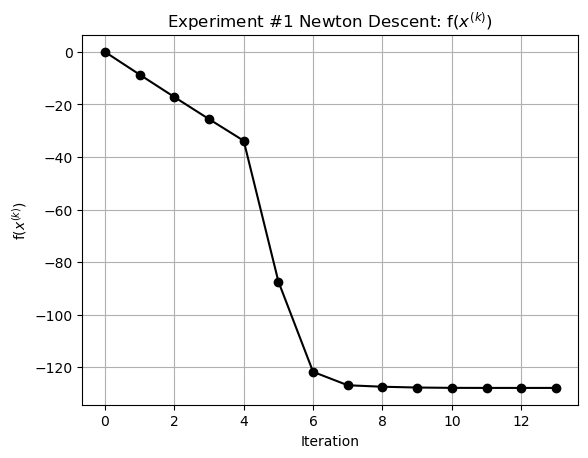

In [56]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #1 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

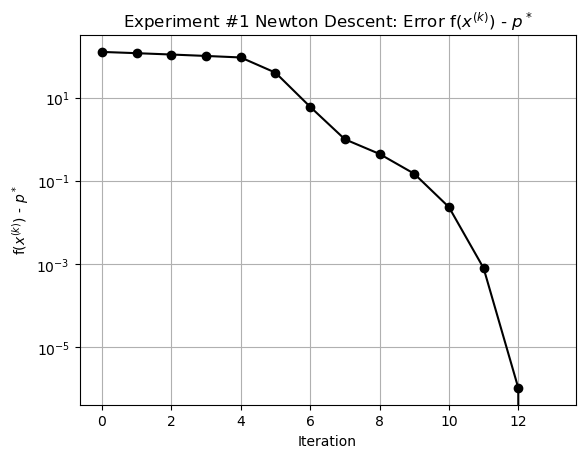

In [57]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [58]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([0.1, 0.1, 0.1, 0.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

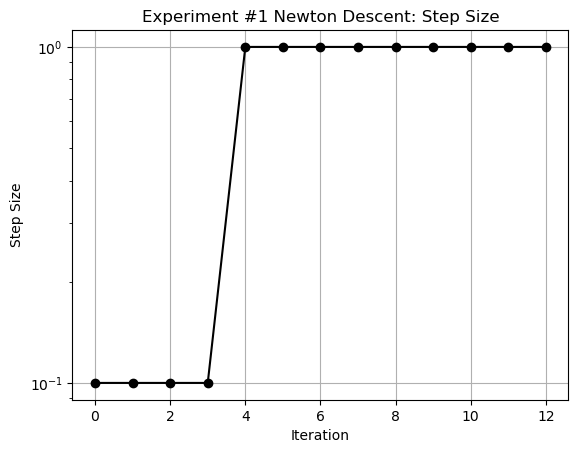

In [59]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #1 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #2: n = 100, m = 200, $\alpha = 0.01$, $\beta = 0.5$ 

In [60]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [61]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447, Norm of Hessian: 2416.405817929144, Newton Parameter: 90.56343833315444
Iteration: 2, Max of A @ x: 0.5386983303123343, Max of x^2: 0.012992570124040894, Current Function Value(Beginning of Iteration): -36.42932752504273, Norm of Gradient: 94.44912638669352, Norm of Hessian: 1925.7774595193955, Newton Parameter: 81.7836532561167
Iteration: 3, Max of A @ x: 0.7965752414508851, Max of x^2: 0.21200451103502357, Current Function Value(Beginning of Iteration): -90.64140146603837, Norm of Gradient: 43.99778074275067, Norm of Hessian: 3380.767636033726, Newton Parameter: 54.767718490716234
Iteration: 4, Max of A @ x: 0.7707618308478674, Max of x^2: 0.9319851498592887, Current Function Value(Beginning of Iteration): -123.44747350999226, Norm of Gradient: 27.11888956900636, Norm of Hessian: 3383.155579700305, Newton Parameter: 8.52764211856767
Iteration: 5

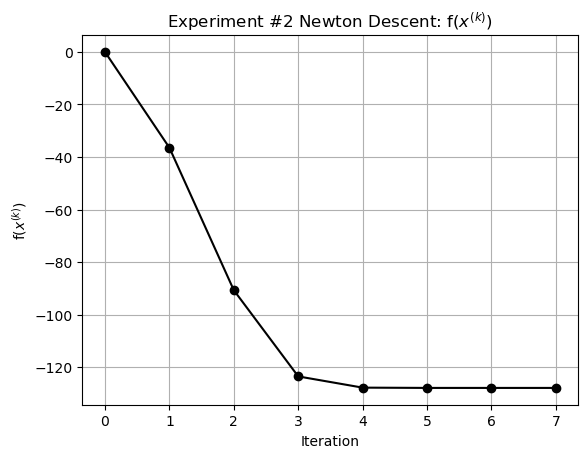

In [62]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #2 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

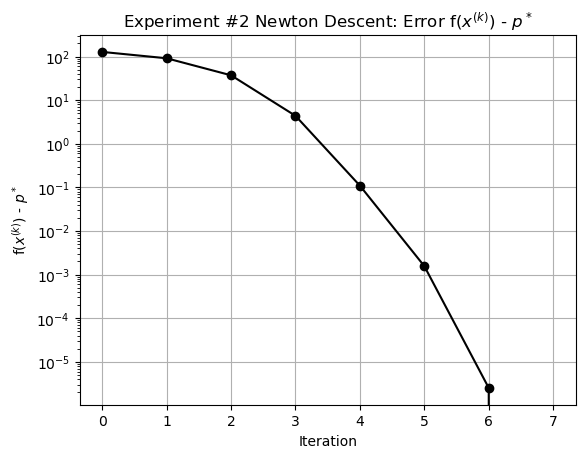

In [63]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [64]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([0.5, 1. , 1. , 1. , 1. , 1. , 1. ])

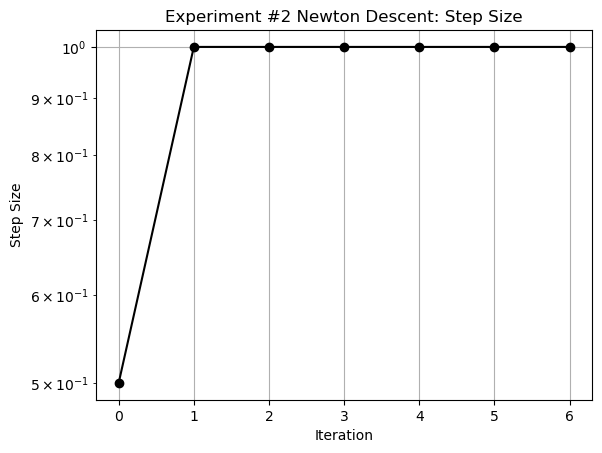

In [65]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #2 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #3: n = 100, m = 200, $\alpha = 0.15$, $\beta = 0.1$ 

In [66]:
#Global Variables
n = 100
m = 200
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [67]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447, Norm of Hessian: 2416.405817929144, Newton Parameter: 90.56343833315444
Iteration: 2, Max of A @ x: 0.10773966606246688, Max of x^2: 0.0005197028049616358, Current Function Value(Beginning of Iteration): -8.630023797973163, Norm of Gradient: 130.30037002317928, Norm of Hessian: 2229.063677787344, Newton Parameter: 89.5133755066185
Iteration: 3, Max of A @ x: 0.2050510002323914, Max of x^2: 0.0023495965769706976, Current Function Value(Beginning of Iteration): -17.15953273958938, Norm of Gradient: 118.39319700990535, Norm of Hessian: 2082.236963155713, Newton Parameter: 88.16174017255055
Iteration: 4, Max of A @ x: 0.29068598638790055, Max of x^2: 0.005944745720924914, Current Function Value(Beginning of Iteration): -25.559748564882955, Norm of Gradient: 107.53645755105855, Norm of Hessian: 1970.2747889424286, Newton Parameter: 86.49004392154205
It

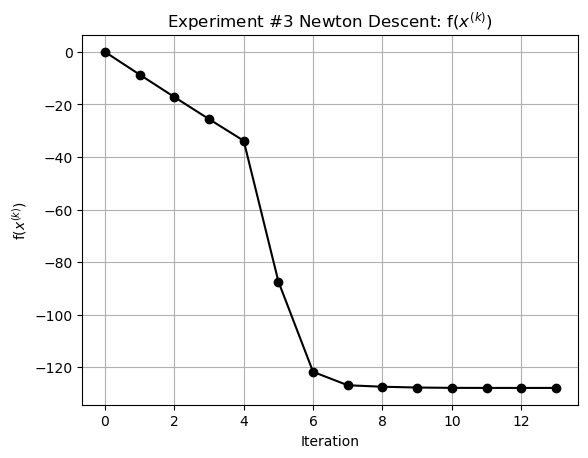

In [68]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #3 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

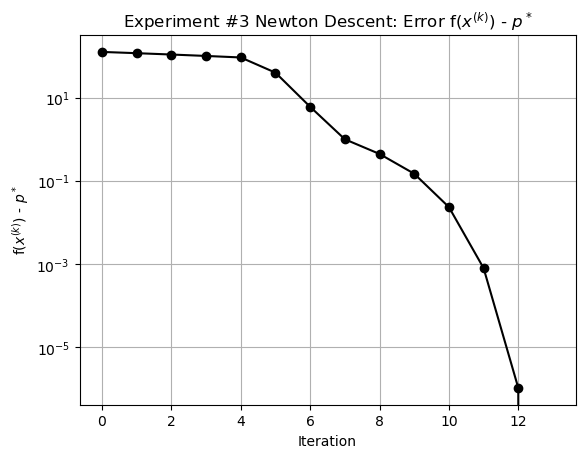

In [69]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed0
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [70]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([0.1, 0.1, 0.1, 0.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ])

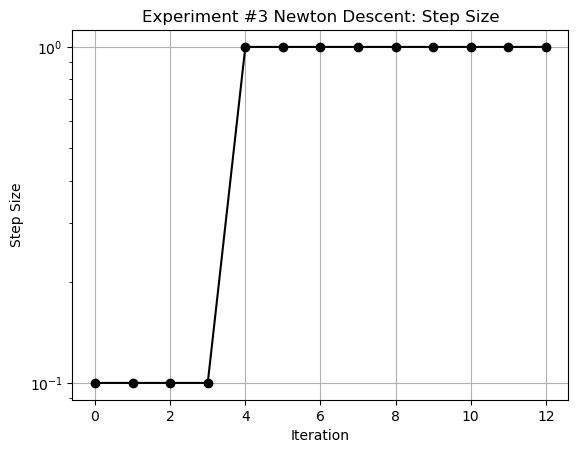

In [71]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #3 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #4: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.1$ 

In [72]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [73]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704, Norm of Hessian: 6967.346437366498, Newton Parameter: 215.28035530231347
Iteration: 2, Max of A @ x: 0.8059671103488835, Max of x^2: 0.055020069365450446, Current Function Value(Beginning of Iteration): -147.61482485321264, Norm of Gradient: 153.00737765400507, Norm of Hessian: 8120.545214296501, Newton Parameter: 221.67649419989843
Iteration: 3, Max of A @ x: 0.6904113113859294, Max of x^2: 0.5599059707563, Current Function Value(Beginning of Iteration): -299.1863853068699, Norm of Gradient: 73.16661514249789, Norm of Hessian: 4946.313806025456, Newton Parameter: 160.80582044961469
Iteration: 4, Max of A @ x: 0.6752437429530096, Max of x^2: 0.647956166119523, Current Function Value(Beginning of Iteration): -314.4821967221029, Norm of Gradient: 66.2109215833691, Norm of Hessian: 4694.287890524916, Newton Parameter: 140.48530175577855
Iteration: 5

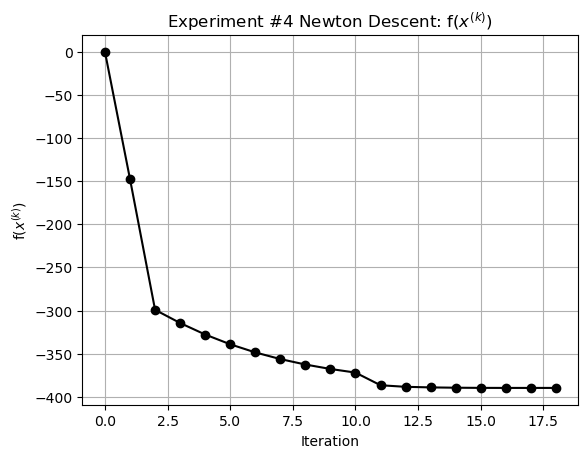

In [74]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #4 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

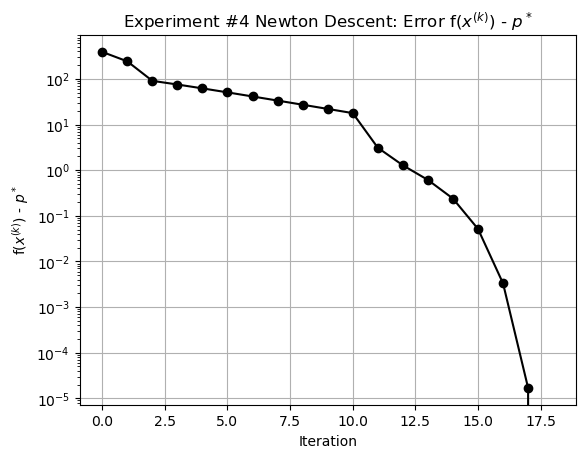

In [75]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #4 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [76]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([1. , 1. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. ])

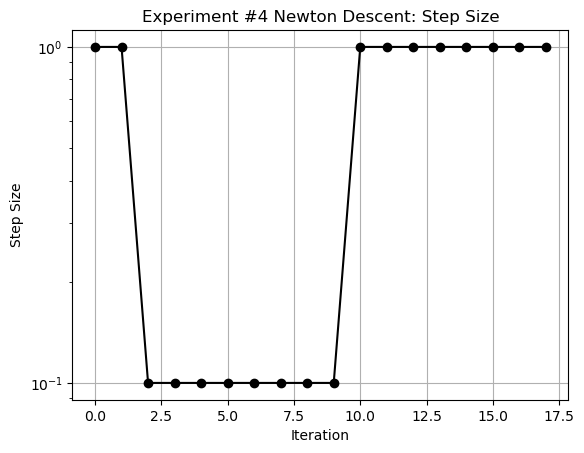

In [77]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #4 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #5: n = 200, m = 400, $\alpha = 0.01$, $\beta = 0.5$ 

In [78]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [79]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704, Norm of Hessian: 6967.346437366498, Newton Parameter: 215.28035530231347
Iteration: 2, Max of A @ x: 0.8059671103488835, Max of x^2: 0.055020069365450446, Current Function Value(Beginning of Iteration): -147.61482485321264, Norm of Gradient: 153.00737765400507, Norm of Hessian: 8120.545214296501, Newton Parameter: 221.67649419989843
Iteration: 3, Max of A @ x: 0.6904113113859294, Max of x^2: 0.5599059707563, Current Function Value(Beginning of Iteration): -299.1863853068699, Norm of Gradient: 73.16661514249789, Norm of Hessian: 4946.313806025456, Newton Parameter: 160.80582044961469
Iteration: 4, Max of A @ x: 0.6524923903036296, Max of x^2: 0.7920824476501073, Current Function Value(Beginning of Iteration): -334.5714573753945, Norm of Gradient: 56.71078264846068, Norm of Hessian: 4379.637370233563, Newton Parameter: 105.1234562388688
Iteration: 

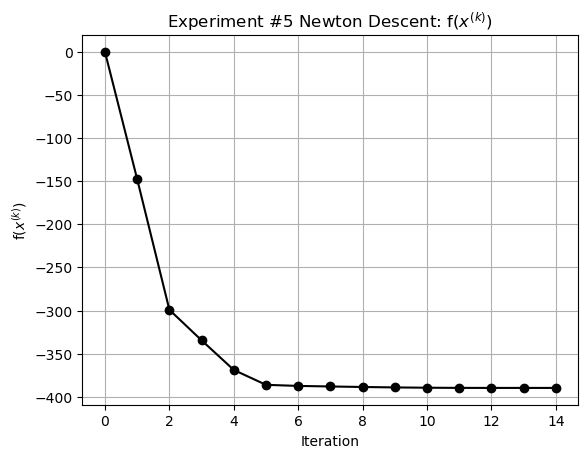

In [80]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #5 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

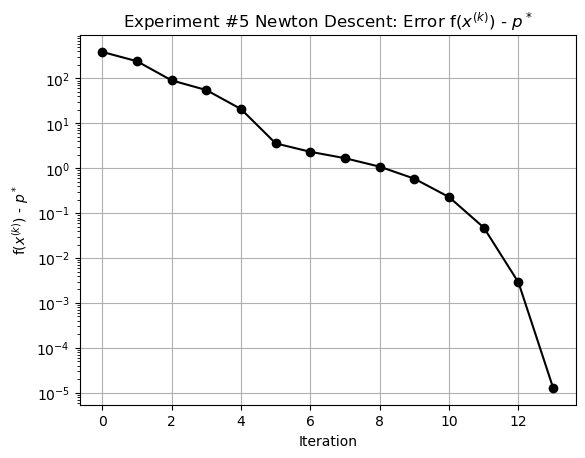

In [81]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
newton_descent_gap_to_optimal = newton_descent_gap_to_optimal[:-1]

plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #5 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [82]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([1.  , 1.  , 0.25, 0.5 , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  ])

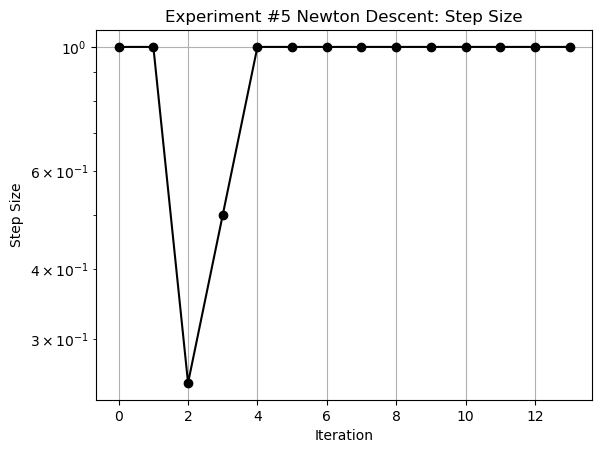

In [83]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #5 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #6: n = 200, m = 400, $\alpha = 0.15$, $\beta = 0.1$ 

In [84]:
#Global Variables
n = 200
m = 400
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [85]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704, Norm of Hessian: 6967.346437366498, Newton Parameter: 215.28035530231347
Iteration: 2, Max of A @ x: 0.8059671103488835, Max of x^2: 0.055020069365450446, Current Function Value(Beginning of Iteration): -147.61482485321264, Norm of Gradient: 153.00737765400507, Norm of Hessian: 8120.545214296501, Newton Parameter: 221.67649419989843
Iteration: 3, Max of A @ x: 0.6904113113859294, Max of x^2: 0.5599059707563, Current Function Value(Beginning of Iteration): -299.1863853068699, Norm of Gradient: 73.16661514249789, Norm of Hessian: 4946.313806025456, Newton Parameter: 160.80582044961469
Iteration: 4, Max of A @ x: 0.6752437429530096, Max of x^2: 0.647956166119523, Current Function Value(Beginning of Iteration): -314.4821967221029, Norm of Gradient: 66.2109215833691, Norm of Hessian: 4694.287890524916, Newton Parameter: 140.48530175577855
Iteration: 5

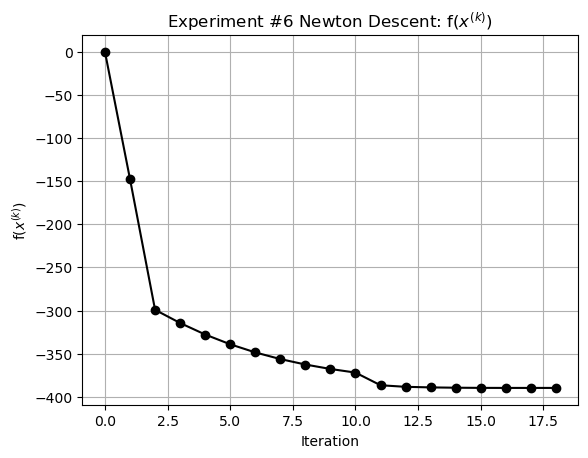

In [86]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #6 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

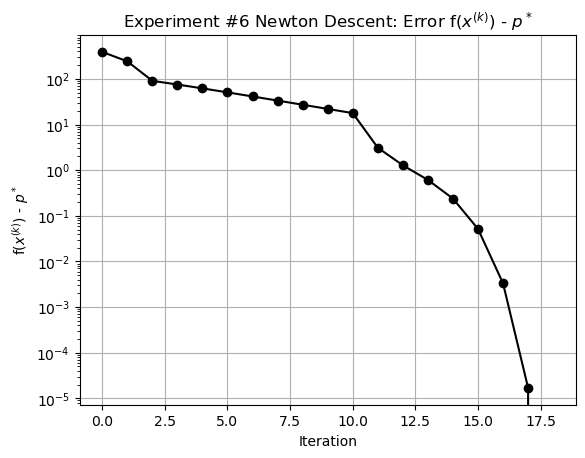

In [87]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed1
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #6 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

In [88]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([1. , 1. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. ])

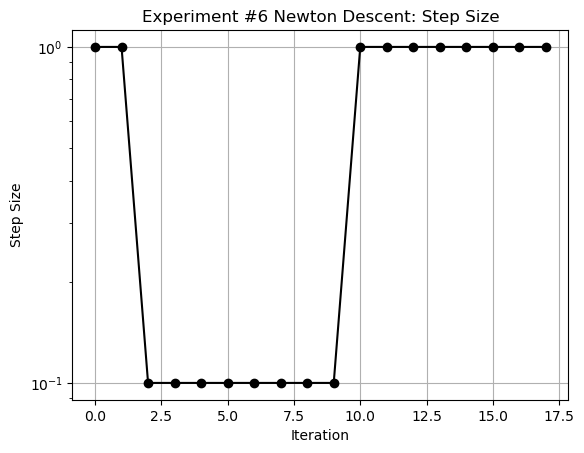

In [89]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #6 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #7: n = 50, m = 100, $\alpha = 0.01, \beta = 0.1$

In [90]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))


In [91]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863, Norm of Hessian: 885.0336613928035, Newton Parameter: 50.10567405040936
Iteration: 2, Max of A @ x: 0.5281960279941088, Max of x^2: 0.11487434319794695, Current Function Value(Beginning of Iteration): -34.01899309673216, Norm of Gradient: 37.207316036089544, Norm of Hessian: 677.3067040136438, Newton Parameter: 41.95520339253577
Iteration: 3, Max of A @ x: 0.43251770389753685, Max of x^2: 0.784181293705887, Current Function Value(Beginning of Iteration): -60.17009465227753, Norm of Gradient: 14.667505149261792, Norm of Hessian: 626.238572694312, Newton Parameter: 10.607163545207596
Iteration: 4, Max of A @ x: 0.5265740932347547, Max of x^2: 0.7719256916592044, Current Function Value(Beginning of Iteration): -65.70220681289987, Norm of Gradient: 5.009060309399606, Norm of Hessian: 745.4131992394742, Newton Parameter: 0.5154966055174186
Iteration: 5

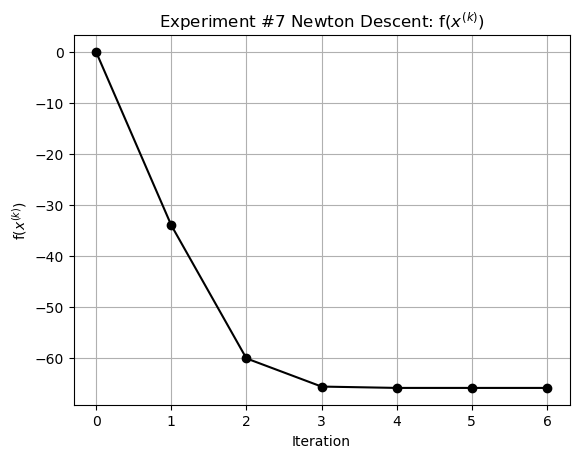

In [92]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #7 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


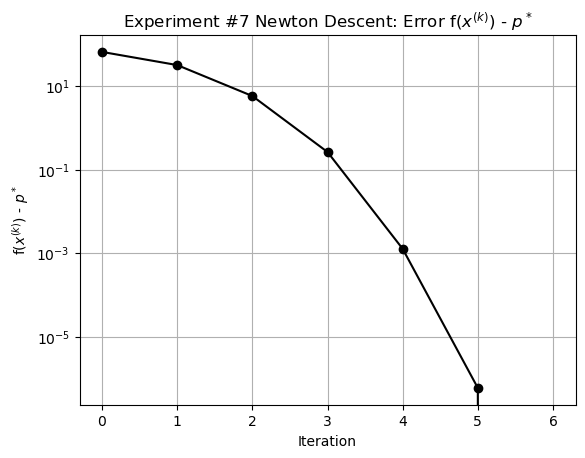

In [93]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed2
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #7 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [94]:
#Print step sizes during Newton's Method
newton_descent_step_sizes

array([1, 1, 1, 1, 1, 1])

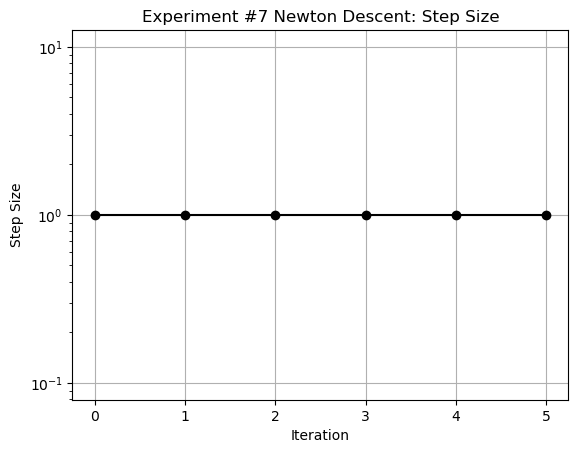

In [95]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #7 Newton Descent: Step Size')
plt.grid(True)
plt.show()

### Experiment #8: n = 50, m = 100, $\alpha = 0.01, \beta = 0.5$

In [96]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.5

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))


In [97]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)


Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863, Norm of Hessian: 885.0336613928035, Newton Parameter: 50.10567405040936
Iteration: 2, Max of A @ x: 0.5281960279941088, Max of x^2: 0.11487434319794695, Current Function Value(Beginning of Iteration): -34.01899309673216, Norm of Gradient: 37.207316036089544, Norm of Hessian: 677.3067040136438, Newton Parameter: 41.95520339253577
Iteration: 3, Max of A @ x: 0.43251770389753685, Max of x^2: 0.784181293705887, Current Function Value(Beginning of Iteration): -60.17009465227753, Norm of Gradient: 14.667505149261792, Norm of Hessian: 626.238572694312, Newton Parameter: 10.607163545207596
Iteration: 4, Max of A @ x: 0.5265740932347547, Max of x^2: 0.7719256916592044, Current Function Value(Beginning of Iteration): -65.70220681289987, Norm of Gradient: 5.009060309399606, Norm of Hessian: 745.4131992394742, Newton Parameter: 0.5154966055174186
Iteration: 5

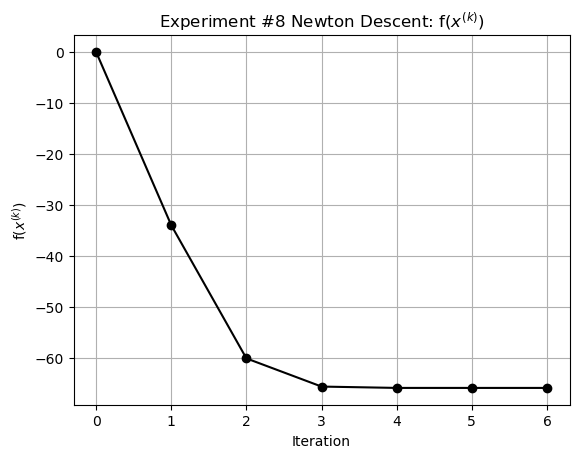

In [98]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #8 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


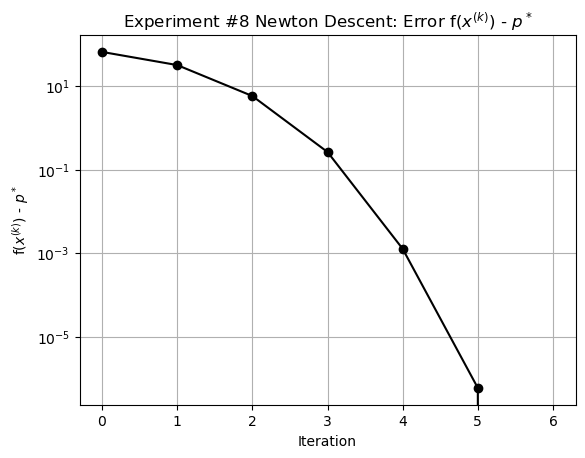

In [99]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed2
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #8 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [100]:
#Print step sizes during Newton's Method
newton_descent_step_sizes


array([1, 1, 1, 1, 1, 1])

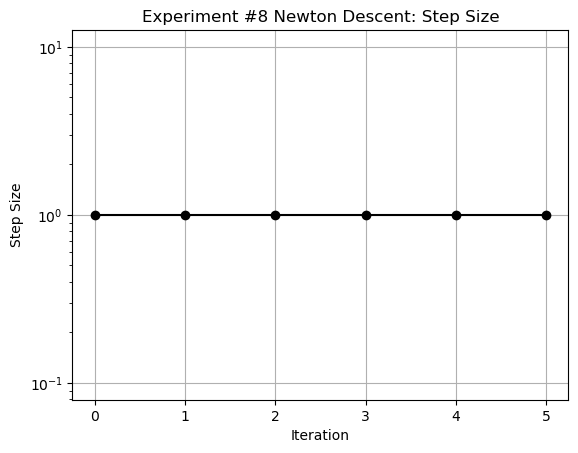

In [101]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #8 Newton Descent: Step Size')
plt.grid(True)
plt.show()


### Experiment #9: n = 50, m = 100, $\alpha = 0.15, \beta = 0.1$

In [102]:
#Global Variables
n = 50
m = 100
alpha = 0.15
beta = 0.1

eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))


In [103]:
#Run Newton's Method
newton_descent_iterates, newton_descent_function_values, newton_descent_step_sizes = newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)


Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863, Norm of Hessian: 885.0336613928035, Newton Parameter: 50.10567405040936
Iteration: 2, Max of A @ x: 0.5281960279941088, Max of x^2: 0.11487434319794695, Current Function Value(Beginning of Iteration): -34.01899309673216, Norm of Gradient: 37.207316036089544, Norm of Hessian: 677.3067040136438, Newton Parameter: 41.95520339253577
Iteration: 3, Max of A @ x: 0.43251770389753685, Max of x^2: 0.784181293705887, Current Function Value(Beginning of Iteration): -60.17009465227753, Norm of Gradient: 14.667505149261792, Norm of Hessian: 626.238572694312, Newton Parameter: 10.607163545207596
Iteration: 4, Max of A @ x: 0.5265740932347547, Max of x^2: 0.7719256916592044, Current Function Value(Beginning of Iteration): -65.70220681289987, Norm of Gradient: 5.009060309399606, Norm of Hessian: 745.4131992394742, Newton Parameter: 0.5154966055174186
Iteration: 5

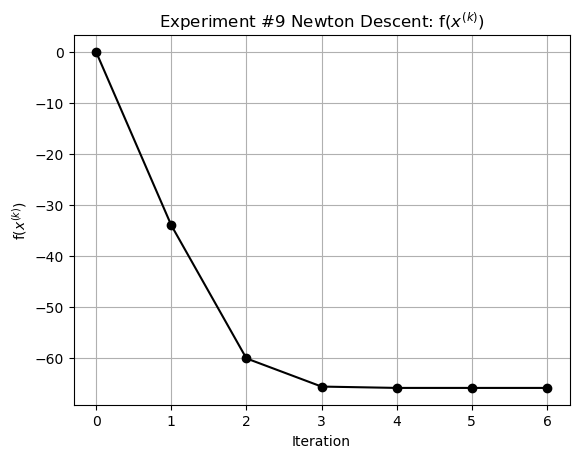

In [104]:
#Plot function values throughout Newton's Method
plt.plot(list(range(len(newton_descent_function_values))), newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #9 Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()


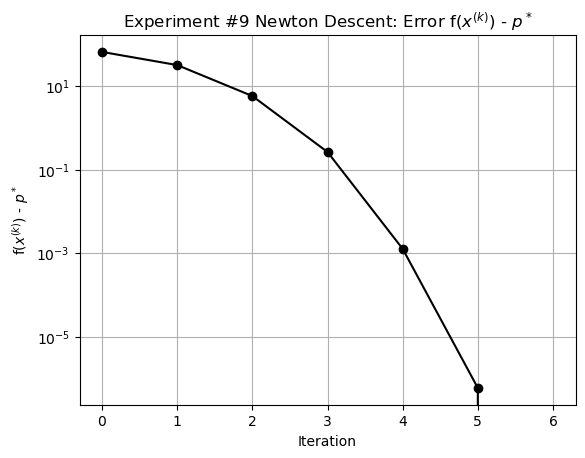

In [105]:
#Plot distance to optimal function value throughout Newton's Method
newton_descent_gap_to_optimal = newton_descent_function_values - p_star_seed2
plt.plot(list(range(len(newton_descent_gap_to_optimal))), newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #9 Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()


In [106]:
#Print step sizes during Newton's Method
newton_descent_step_sizes


array([1, 1, 1, 1, 1, 1])

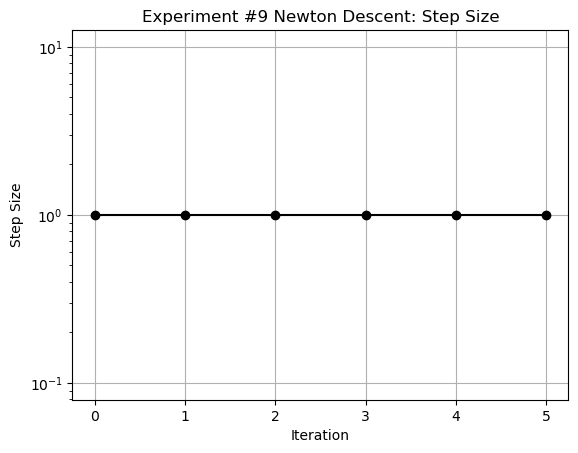

In [107]:
#Plot step sizes during Newton's Method
plt.plot(list(range(len(newton_descent_step_sizes))), newton_descent_step_sizes, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'Step Size')
plt.yscale('log')
plt.title(r'Experiment #9 Newton Descent: Step Size')
plt.grid(True)
plt.show()


Observations:
- Backtracking Parameters $\alpha$ and $\beta$ do not affect the performance of Newton's Method that much when compared to Gradient Descent
- Performance is scaling well with problem size


## 9.31 (a)

### Experiment #1

In [108]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [109]:
#Run Newton's Method where Hessian is reused every 1 iteration
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_step_sizes_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447, Norm of Hessian: 2416.405817929144, Newton Parameter: 90.56343833315444
Iteration: 2, Max of A @ x: 0.5386983303123343, Max of x^2: 0.012992570124040894, Current Function Value(Beginning of Iteration): -36.42932752504273, Norm of Gradient: 94.44912638669352, Norm of Hessian: 1925.7774595193955, Newton Parameter: 81.7836532561167
Iteration: 3, Max of A @ x: 0.7965752414508851, Max of x^2: 0.21200451103502357, Current Function Value(Beginning of Iteration): -90.64140146603837, Norm of Gradient: 43.99778074275067, Norm of Hessian: 3380.767636033726, Newton Parameter: 54.767718490716234
Iteration: 4, Max of A @ x: 0.7707618308478674, Max of x^2: 0.9319851498592887, Current Function Value(Beginning of Iteration): -123.44747350999226, Norm of Gradient: 27.11888956900636, Norm of Hessian: 3383.155579700305, Newton Parameter: 8.52764211856767
Iteration: 5

In [110]:
#Run Newton's Method where Hessian is reused every 2 iteration
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_step_sizes_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447, Norm of Hessian: 2416.405817929144, Newton Parameter: 90.56343833315444
Iteration: 2, Max of A @ x: 0.5386983303123343, Max of x^2: 0.012992570124040894, Current Function Value(Beginning of Iteration): -36.42932752504273, Norm of Gradient: 94.44912638669352, Norm of Hessian: 2416.405817929144, Newton Parameter: 38.155703580885834
Iteration: 3, Max of A @ x: 0.8938305684946963, Max of x^2: 0.07012206548018318, Current Function Value(Beginning of Iteration): -66.32907785344261, Norm of Gradient: 92.52248192246248, Norm of Hessian: 7882.5416885844925, Newton Parameter: 69.65834046595747
Iteration: 4, Max of A @ x: 0.832531677334252, Max of x^2: 0.5155017323266012, Current Function Value(Beginning of Iteration): -111.65326560769061, Norm of Gradient: 32.10245534670068, Norm of Hessian: 7882.5416885844925, Newton Parameter: 11.776180764386613
Iteration

In [111]:
#Run Newton's Method where Hessian is reused every 5 iteration
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_step_sizes_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447, Norm of Hessian: 2416.405817929144, Newton Parameter: 90.56343833315444
Iteration: 2, Max of A @ x: 0.5386983303123343, Max of x^2: 0.012992570124040894, Current Function Value(Beginning of Iteration): -36.42932752504273, Norm of Gradient: 94.44912638669352, Norm of Hessian: 2416.405817929144, Newton Parameter: 38.155703580885834
Iteration: 3, Max of A @ x: 0.8938305684946963, Max of x^2: 0.07012206548018318, Current Function Value(Beginning of Iteration): -66.32907785344261, Norm of Gradient: 92.52248192246248, Norm of Hessian: 2416.405817929144, Newton Parameter: 35.58274021218923
Iteration: 4, Max of A @ x: 0.6846809900758233, Max of x^2: 0.08668200945628167, Current Function Value(Beginning of Iteration): -70.53686562582435, Norm of Gradient: 68.42166211918573, Norm of Hessian: 2416.405817929144, Newton Parameter: 23.942842304933666
Iteration:

In [112]:
#Run Newton's Method where Hessian is reused every 10 iteration
reused_newton_descent_iterates_N10, reused_newton_descent_function_values_N10, reused_newton_descent_step_sizes_N10 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 10)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447, Norm of Hessian: 2416.405817929144, Newton Parameter: 90.56343833315444
Iteration: 2, Max of A @ x: 0.5386983303123343, Max of x^2: 0.012992570124040894, Current Function Value(Beginning of Iteration): -36.42932752504273, Norm of Gradient: 94.44912638669352, Norm of Hessian: 2416.405817929144, Newton Parameter: 38.155703580885834
Iteration: 3, Max of A @ x: 0.8938305684946963, Max of x^2: 0.07012206548018318, Current Function Value(Beginning of Iteration): -66.32907785344261, Norm of Gradient: 92.52248192246248, Norm of Hessian: 2416.405817929144, Newton Parameter: 35.58274021218923
Iteration: 4, Max of A @ x: 0.6846809900758233, Max of x^2: 0.08668200945628167, Current Function Value(Beginning of Iteration): -70.53686562582435, Norm of Gradient: 68.42166211918573, Norm of Hessian: 2416.405817929144, Newton Parameter: 23.942842304933666
Iteration:

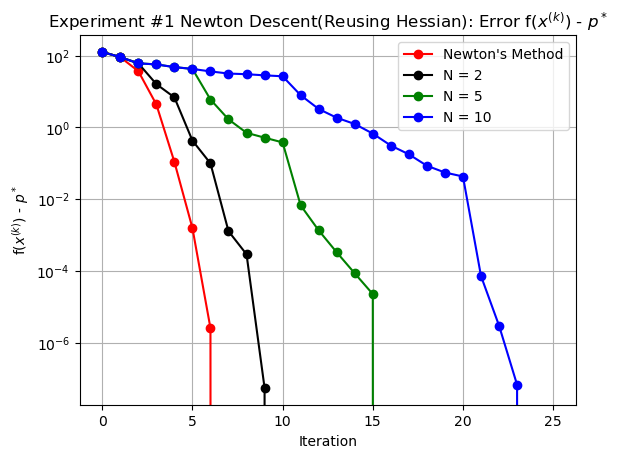

In [113]:
#Plot distance to optimal function value throughout Newton's Method for N = 1, 2, 5, 10
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_seed0
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_seed0
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_seed0
reused_newton_descent_gap_to_optimal_N10 = reused_newton_descent_function_values_N10 - p_star_seed0

# print(f"Gap to Optimal for N = 1: {reused_newton_descent_gap_to_optimal_N1}")
# print(f"Gap to Optimal for N = 2: {reused_newton_descent_gap_to_optimal_N2}")
# print(f"Gap to Optimal for N = 5: {reused_newton_descent_gap_to_optimal_N5}")
# print(f"Gap to Optimal for N = 10: {reused_newton_descent_gap_to_optimal_N10}")

line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')
line4, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N10))), reused_newton_descent_gap_to_optimal_N10, marker='o', color='blue', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3, line4], labels=['Newton\'s Method', 'N = 2', 'N = 5', 'N = 10'])
plt.grid(True)
plt.show()

### Experiment #2

In [114]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [115]:
#Run Newton's Method where Hessian is reused every 1 iteration
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_step_sizes_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704, Norm of Hessian: 6967.346437366498, Newton Parameter: 215.28035530231347
Iteration: 2, Max of A @ x: 0.8059671103488835, Max of x^2: 0.055020069365450446, Current Function Value(Beginning of Iteration): -147.61482485321264, Norm of Gradient: 153.00737765400507, Norm of Hessian: 8120.545214296501, Newton Parameter: 221.67649419989843
Iteration: 3, Max of A @ x: 0.6904113113859294, Max of x^2: 0.5599059707563, Current Function Value(Beginning of Iteration): -299.1863853068699, Norm of Gradient: 73.16661514249789, Norm of Hessian: 4946.313806025456, Newton Parameter: 160.80582044961469
Iteration: 4, Max of A @ x: 0.6524923903036296, Max of x^2: 0.7920824476501073, Current Function Value(Beginning of Iteration): -334.5714573753945, Norm of Gradient: 56.71078264846068, Norm of Hessian: 4379.637370233563, Newton Parameter: 105.1234562388688
Iteration: 

In [116]:
#Run Newton's Method where Hessian is reused every 2 iteration
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_step_sizes_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704, Norm of Hessian: 6967.346437366498, Newton Parameter: 215.28035530231347
Iteration: 2, Max of A @ x: 0.8059671103488835, Max of x^2: 0.055020069365450446, Current Function Value(Beginning of Iteration): -147.61482485321264, Norm of Gradient: 153.00737765400507, Norm of Hessian: 6967.346437366498, Newton Parameter: 60.24914444413938
Iteration: 3, Max of A @ x: 0.5862985680997163, Max of x^2: 0.12086177818598308, Current Function Value(Beginning of Iteration): -192.84246190752393, Norm of Gradient: 128.96083105742017, Norm of Hessian: 4828.105372341292, Newton Parameter: 223.2027298428562
Iteration: 4, Max of A @ x: 0.5377821537304626, Max of x^2: 0.4266294652748753, Current Function Value(Beginning of Iteration): -282.47948385719707, Norm of Gradient: 81.53188332195268, Norm of Hessian: 4828.105372341292, Newton Parameter: 92.68765041678546
Iterat

In [117]:
#Run Newton's Method where Hessian is reused every 5 iteration
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_step_sizes_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704, Norm of Hessian: 6967.346437366498, Newton Parameter: 215.28035530231347
Iteration: 2, Max of A @ x: 0.8059671103488835, Max of x^2: 0.055020069365450446, Current Function Value(Beginning of Iteration): -147.61482485321264, Norm of Gradient: 153.00737765400507, Norm of Hessian: 6967.346437366498, Newton Parameter: 60.24914444413938
Iteration: 3, Max of A @ x: 0.5862985680997163, Max of x^2: 0.12086177818598308, Current Function Value(Beginning of Iteration): -192.84246190752393, Norm of Gradient: 128.96083105742017, Norm of Hessian: 6967.346437366498, Newton Parameter: 39.60851011988946
Iteration: 4, Max of A @ x: 0.7051362757142828, Max of x^2: 0.20651706799417843, Current Function Value(Beginning of Iteration): -226.92804145918473, Norm of Gradient: 101.85664612648884, Norm of Hessian: 6967.346437366498, Newton Parameter: 27.342385892287755
Ite

In [118]:
#Run Newton's Method where Hessian is reused every 10 iteration
reused_newton_descent_iterates_N10, reused_newton_descent_function_values_N10, reused_newton_descent_step_sizes_N10 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 10)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704, Norm of Hessian: 6967.346437366498, Newton Parameter: 215.28035530231347
Iteration: 2, Max of A @ x: 0.8059671103488835, Max of x^2: 0.055020069365450446, Current Function Value(Beginning of Iteration): -147.61482485321264, Norm of Gradient: 153.00737765400507, Norm of Hessian: 6967.346437366498, Newton Parameter: 60.24914444413938
Iteration: 3, Max of A @ x: 0.5862985680997163, Max of x^2: 0.12086177818598308, Current Function Value(Beginning of Iteration): -192.84246190752393, Norm of Gradient: 128.96083105742017, Norm of Hessian: 6967.346437366498, Newton Parameter: 39.60851011988946
Iteration: 4, Max of A @ x: 0.7051362757142828, Max of x^2: 0.20651706799417843, Current Function Value(Beginning of Iteration): -226.92804145918473, Norm of Gradient: 101.85664612648884, Norm of Hessian: 6967.346437366498, Newton Parameter: 27.342385892287755
Ite

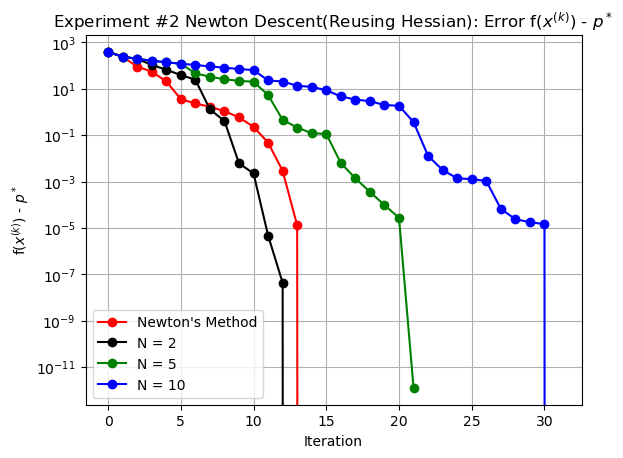

In [119]:
#Plot distance to optimal function value throughout Newton's Method for N = 1, 2, 5, 10
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_seed1
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_seed1
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_seed1
reused_newton_descent_gap_to_optimal_N10 = reused_newton_descent_function_values_N10 - p_star_seed1

line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')
line4, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N10))), reused_newton_descent_gap_to_optimal_N10, marker='o', color='blue', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3, line4], labels=['Newton\'s Method', 'N = 2', 'N = 5', 'N = 10'])
plt.grid(True)
plt.show()

### Experiment #3

In [120]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [121]:
#Run Newton's Method where Hessian is reused every 1 iteration
reused_newton_descent_iterates_N1, reused_newton_descent_function_values_N1, reused_newton_descent_step_sizes_N1 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 1)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863, Norm of Hessian: 885.0336613928035, Newton Parameter: 50.10567405040936
Iteration: 2, Max of A @ x: 0.5281960279941088, Max of x^2: 0.11487434319794695, Current Function Value(Beginning of Iteration): -34.01899309673216, Norm of Gradient: 37.207316036089544, Norm of Hessian: 677.3067040136438, Newton Parameter: 41.95520339253577
Iteration: 3, Max of A @ x: 0.43251770389753685, Max of x^2: 0.784181293705887, Current Function Value(Beginning of Iteration): -60.17009465227753, Norm of Gradient: 14.667505149261792, Norm of Hessian: 626.238572694312, Newton Parameter: 10.607163545207596
Iteration: 4, Max of A @ x: 0.5265740932347547, Max of x^2: 0.7719256916592044, Current Function Value(Beginning of Iteration): -65.70220681289987, Norm of Gradient: 5.009060309399606, Norm of Hessian: 745.4131992394742, Newton Parameter: 0.5154966055174186
Iteration: 5

In [122]:
#Run Newton's Method where Hessian is reused every 2 iteration
reused_newton_descent_iterates_N2, reused_newton_descent_function_values_N2, reused_newton_descent_step_sizes_N2 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 2)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863, Norm of Hessian: 885.0336613928035, Newton Parameter: 50.10567405040936
Iteration: 2, Max of A @ x: 0.5281960279941088, Max of x^2: 0.11487434319794695, Current Function Value(Beginning of Iteration): -34.01899309673216, Norm of Gradient: 37.207316036089544, Norm of Hessian: 885.0336613928035, Newton Parameter: 11.389692370499576
Iteration: 3, Max of A @ x: 0.3801524885258384, Max of x^2: 0.24888591045474653, Current Function Value(Beginning of Iteration): -43.89600278192699, Norm of Gradient: 29.550000672691777, Norm of Hessian: 620.1204604978981, Newton Parameter: 34.40952986405544
Iteration: 4, Max of A @ x: 0.40915710090650975, Max of x^2: 0.5728936665081742, Current Function Value(Beginning of Iteration): -57.29917782743856, Norm of Gradient: 17.676529191162277, Norm of Hessian: 620.1204604978981, Newton Parameter: 11.407936837998994
Iteratio

In [123]:
#Run Newton's Method where Hessian is reused every 5 iteration
reused_newton_descent_iterates_N5, reused_newton_descent_function_values_N5, reused_newton_descent_step_sizes_N5 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 5)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863, Norm of Hessian: 885.0336613928035, Newton Parameter: 50.10567405040936
Iteration: 2, Max of A @ x: 0.5281960279941088, Max of x^2: 0.11487434319794695, Current Function Value(Beginning of Iteration): -34.01899309673216, Norm of Gradient: 37.207316036089544, Norm of Hessian: 885.0336613928035, Newton Parameter: 11.389692370499576
Iteration: 3, Max of A @ x: 0.3801524885258384, Max of x^2: 0.24888591045474653, Current Function Value(Beginning of Iteration): -43.89600278192699, Norm of Gradient: 29.550000672691777, Norm of Hessian: 885.0336613928035, Newton Parameter: 6.698695925403042
Iteration: 4, Max of A @ x: 0.47824974028085154, Max of x^2: 0.3578422067398876, Current Function Value(Beginning of Iteration): -49.90143646550652, Norm of Gradient: 24.133004600841616, Norm of Hessian: 885.0336613928035, Newton Parameter: 4.473573632892105
Iteration

In [124]:
#Run Newton's Method where Hessian is reused every 10 iteration
reused_newton_descent_iterates_N10, reused_newton_descent_function_values_N10, reused_newton_descent_step_sizes_N10 = reuse_newton_descent(f, f_gradient, f_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta, N = 10)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863, Norm of Hessian: 885.0336613928035, Newton Parameter: 50.10567405040936
Iteration: 2, Max of A @ x: 0.5281960279941088, Max of x^2: 0.11487434319794695, Current Function Value(Beginning of Iteration): -34.01899309673216, Norm of Gradient: 37.207316036089544, Norm of Hessian: 885.0336613928035, Newton Parameter: 11.389692370499576
Iteration: 3, Max of A @ x: 0.3801524885258384, Max of x^2: 0.24888591045474653, Current Function Value(Beginning of Iteration): -43.89600278192699, Norm of Gradient: 29.550000672691777, Norm of Hessian: 885.0336613928035, Newton Parameter: 6.698695925403042
Iteration: 4, Max of A @ x: 0.47824974028085154, Max of x^2: 0.3578422067398876, Current Function Value(Beginning of Iteration): -49.90143646550652, Norm of Gradient: 24.133004600841616, Norm of Hessian: 885.0336613928035, Newton Parameter: 4.473573632892105
Iteration

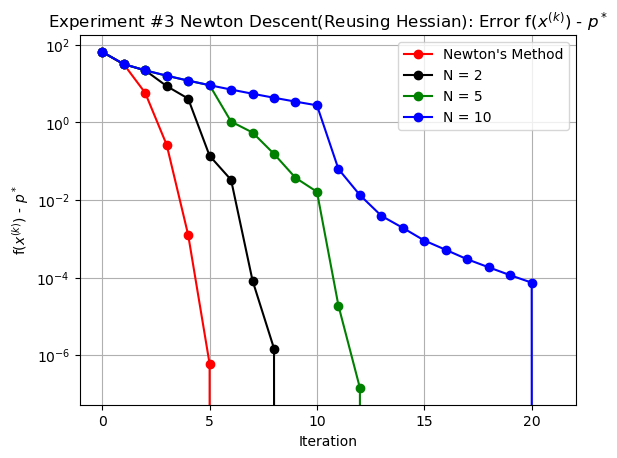

In [125]:
#Plot distance to optimal function value throughout Newton's Method for N = 1, 2, 5, 10
reused_newton_descent_gap_to_optimal_N1 = reused_newton_descent_function_values_N1 - p_star_seed2
reused_newton_descent_gap_to_optimal_N2 = reused_newton_descent_function_values_N2 - p_star_seed2
reused_newton_descent_gap_to_optimal_N5 = reused_newton_descent_function_values_N5 - p_star_seed2
reused_newton_descent_gap_to_optimal_N10 = reused_newton_descent_function_values_N10 - p_star_seed2

# print(f"Gap to Optimal for N = 1: {reused_newton_descent_gap_to_optimal_N1}")
# print(f"Gap to Optimal for N = 2: {reused_newton_descent_gap_to_optimal_N2}")
# print(f"Gap to Optimal for N = 5: {reused_newton_descent_gap_to_optimal_N5}")
# print(f"Gap to Optimal for N = 10: {reused_newton_descent_gap_to_optimal_N10}")

line1, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N1))), reused_newton_descent_gap_to_optimal_N1, marker='o', color='red', linestyle='-')
line2, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N2))), reused_newton_descent_gap_to_optimal_N2, marker='o', color='black', linestyle='-')
line3, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N5))), reused_newton_descent_gap_to_optimal_N5, marker='o', color='green', linestyle='-')
line4, = plt.plot(list(range(len(reused_newton_descent_gap_to_optimal_N10))), reused_newton_descent_gap_to_optimal_N10, marker='o', color='blue', linestyle='-')

plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Newton Descent(Reusing Hessian): Error f($x^{(k)}$) - $p^*$')
plt.legend(handles=[line1, line2, line3, line4], labels=['Newton\'s Method', 'N = 2', 'N = 5', 'N = 10'])
plt.grid(True)
plt.show()

Observations: 
- As N increases, the speed of convergence decreases

## 9.31 (b)

### Experiment #1

In [126]:
#Global Variables
n = 100
m = 200
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(0)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [127]:
#Run Newton's Method where Hessian is approximated by its diagonal
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_step_sizes = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 143.3595666732447, Norm of Hessian: 1990.0787183895427, Newton Parameter: 101.21071023203918
Iteration: 2, Max of A @ x: 0.793518851437893, Max of x^2: 0.007609149649998936, Current Function Value(Beginning of Iteration): -35.657428688192525, Norm of Gradient: 87.27987168614656, Norm of Hessian: 2024.8311154631024, Newton Parameter: 39.14360445005548
Iteration: 3, Max of A @ x: 0.9678366449352696, Max of x^2: 0.03808066203143677, Current Function Value(Beginning of Iteration): -56.85784338121833, Norm of Gradient: 303.4884461544288, Norm of Hessian: 16243.790700687081, Newton Parameter: 67.70064165189955
Iteration: 4, Max of A @ x: 0.9394146392316809, Max of x^2: 0.07000176179601242, Current Function Value(Beginning of Iteration): -58.1581366097658, Norm of Gradient: 210.02123566839052, Norm of Hessian: 8200.060097396941, Newton Parameter: 67.46818611744757
Iteratio

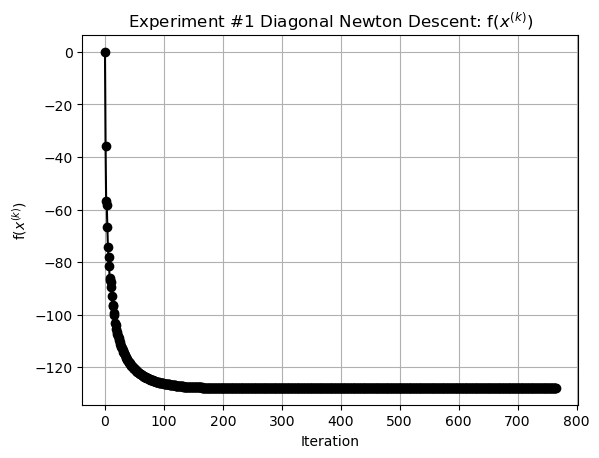

In [128]:
#Plot function values throughout Newton's Method where the Hessian is replaced by its diagonal
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #1 Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

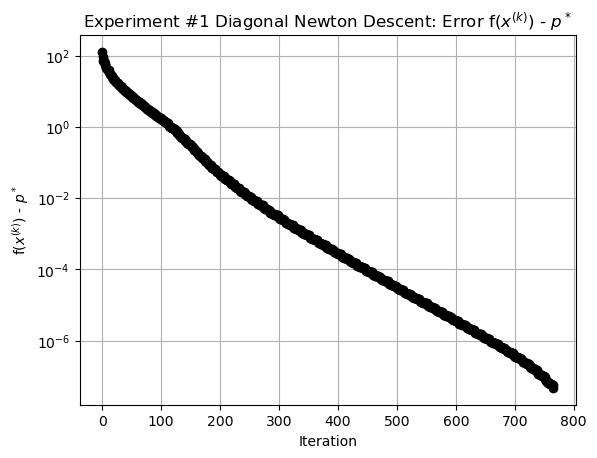

In [129]:
#Plot distance to optimal function value throughout Newton's Method where the Hessian is replaced by its diagonal
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star_seed0
plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #1 Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

### Experiment #2

In [130]:
#Global Variables
n = 200
m = 400
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(1)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [131]:
#Run Newton's Method where Hessian is approximated by its diagonal
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_step_sizes = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 298.43899730195704, Norm of Hessian: 5696.43369592199, Newton Parameter: 222.31961962559689
Iteration: 2, Max of A @ x: 0.9064553522594168, Max of x^2: 0.005830245573278131, Current Function Value(Beginning of Iteration): -74.47088997701422, Norm of Gradient: 234.73083679984867, Norm of Hessian: 8314.13503529053, Newton Parameter: 97.56939417329451
Iteration: 3, Max of A @ x: 0.7390912180453446, Max of x^2: 0.010312609620057261, Current Function Value(Beginning of Iteration): -95.76718941426738, Norm of Gradient: 169.1575119550086, Norm of Hessian: 4838.262034531397, Newton Parameter: 85.75321999081358
Iteration: 4, Max of A @ x: 0.9193517010860042, Max of x^2: 0.019694859603175043, Current Function Value(Beginning of Iteration): -125.2859520884395, Norm of Gradient: 243.38675094609005, Norm of Hessian: 9101.213289244868, Newton Parameter: 88.68743101758913
Iteratio

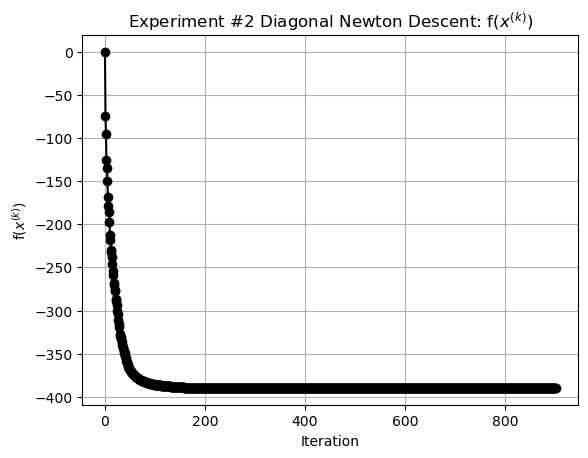

In [132]:
#Plot function values throughout Newton's Method where the Hessian is replaced by its diagonal
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #2 Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

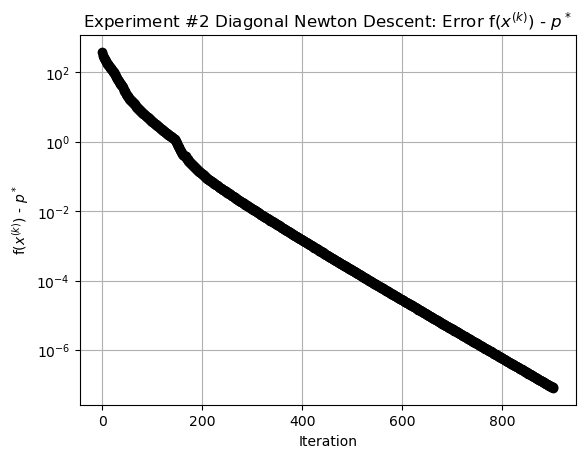

In [133]:
#Plot distance to optimal function value throughout Newton's Method where the Hessian is replaced by its diagonal
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star_seed1
plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #2 Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

### Experiment #3

In [134]:
#Global Variables
n = 50
m = 100
alpha = 0.01
beta = 0.5
eta = 1e-8
max_iter = 2000

x0 = np.zeros(shape = (n, 1)) #initial point will always start at 0 for all experiments

#randomly generate A from normal distribution
np.random.seed(2)
A = np.random.normal(loc = 0, scale = 1, size = (m, n))

In [135]:
#Run Newton's Method where Hessian is approximated by its diagonal
diagonal_newton_descent_iterates, diagonal_newton_descent_function_values, diagonal_newton_descent_step_sizes = diagonal_newton_descent(f, f_gradient, f_diagonal_hessian, f_backtracking_algorithm, A, x0, max_iter, eta, alpha, beta)

Iteration: 1, Max of A @ x: 0.0, Max of x^2: 0.0, Current Function Value(Beginning of Iteration): -0.0, Norm of Gradient: 76.01734082637863, Norm of Hessian: 734.7432189866522, Newton Parameter: 55.255958728867974
Iteration: 2, Max of A @ x: 0.5733378085028176, Max of x^2: 0.010574588570141406, Current Function Value(Beginning of Iteration): -19.801515453637258, Norm of Gradient: 42.496246254707934, Norm of Hessian: 617.8539968436454, Newton Parameter: 20.830893433781988
Iteration: 3, Max of A @ x: 0.581921414355355, Max of x^2: 0.06636688646319995, Current Function Value(Beginning of Iteration): -35.76472614038697, Norm of Gradient: 29.41111403332762, Norm of Hessian: 558.285333401811, Newton Parameter: 11.459664158211856
Iteration: 4, Max of A @ x: 0.6759429116901818, Max of x^2: 0.12389692013049844, Current Function Value(Beginning of Iteration): -40.48858027653486, Norm of Gradient: 27.010598751881584, Norm of Hessian: 590.9144578727228, Newton Parameter: 8.68308300253899
Iteration

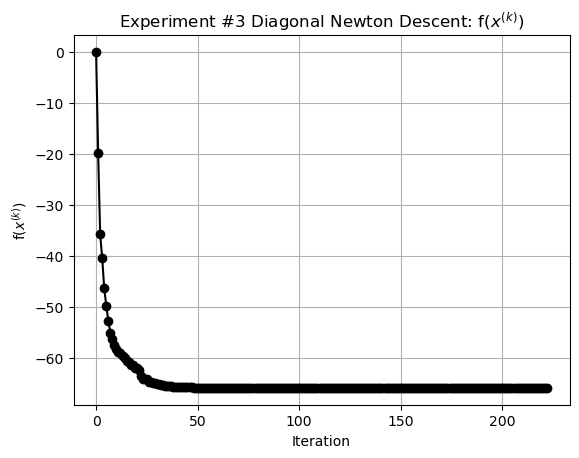

In [136]:
#Plot function values throughout Newton's Method where the Hessian is replaced by its diagonal
plt.plot(list(range(len(diagonal_newton_descent_function_values))), diagonal_newton_descent_function_values, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$)')
plt.title(r'Experiment #3 Diagonal Newton Descent: f($x^{(k)}$)')
plt.grid(True)
plt.show()

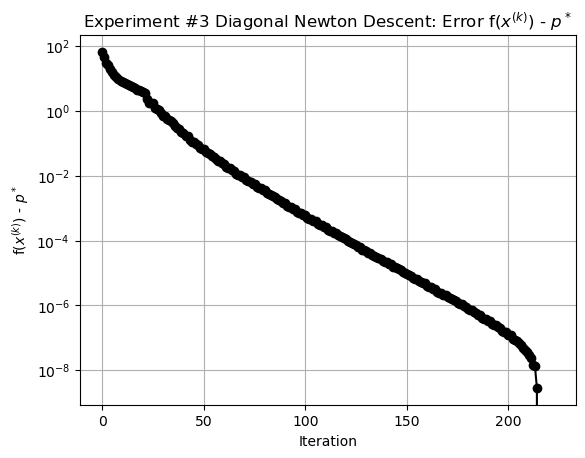

In [137]:
#Plot distance to optimal function value throughout Newton's Method where the Hessian is replaced by its diagonal
diagonal_newton_descent_gap_to_optimal = diagonal_newton_descent_function_values - p_star_seed2
plt.plot(list(range(len(diagonal_newton_descent_gap_to_optimal))), diagonal_newton_descent_gap_to_optimal, marker='o', color='black', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel(r'f($x^{(k)}$) - $p^*$')
plt.yscale('log')
plt.title(r'Experiment #3 Diagonal Newton Descent: Error f($x^{(k)}$) - $p^*$')
plt.grid(True)
plt.show()

Observations: 
- When we are using the Diagonal Approximation of the Hessian, the convergence behavior strongly resembles that of the Gradient Descent Method